# Windows of Opportunity: Increasing employee retention through candidate promotability and promotion window identification.

[Nikhil Gupta](guptan@mail.smu.edu), [Hayley Horn](hhorn@mail.smu.edu), [Max Moro](mmoro@email.smu.edu), [Michael Tieu](mtieu@mail.smu.edu).


## Table of Contents <a class="anchor" id="TOC"></a><br>

<font size = 4>[Business Purpose](#Section1)</font>

<font size = 4>[Data Preparation](#Section2) </font> <br>
* [Basic Setup](#DP_Setup)<br>
* [Loading Functions](#DP_Loading)<br>
* [Data Processing](#DP_DP)<br>
* [Final Data Set](#DP_Final)<br>

<font size = 4>[Modeling and Evaulation](#Section3) </font><br>
* [Evaluation Metrics](#ME_Metrics)<br>
* [Test/Train Split](#<ME_Split)<br>

<font size = 4>[Task 1: Promotion Flag (Classification)](#Section4)</font> <br>
* [Model One - SVM](#PF_M1)<br>
* [Model Two - Random Forest](#PF_M2) <br>
* [Model Three - KNN](#PF_M3)<br>
* [Model Analysis](#PF_MA)<br>
* [Model Comparison](#PF_MC) <br>
* [Important Attributes](#PF_IA)<br>

<font size = 4>[Task 2: Estimated Months Since Promotion (Classification)](#Section5)</font><br>
* [Model One - SVM](#EM_M1)</font><br>
* [Model Two - Random Forest](#EM_M2) <br>
* [Model Three - KNN](#EM_M3)<br>
* [Model Analysis](#EM_MA)<br>
* [Model Comparison](#EM_MC) <br>
* [Important Attributes](#EM_IA)<br>


<font size = 4>[Deployment](#Section8)</font>

<font size = 4>[Exceptional Work](#Section9) </font>
* [Grid Search](#EW_1)<br>
* [Custom Metrics](#EW_2)<br>

<font size = 4>[Conclusion](#Section10) </font>

<font size = 4>[References](#Section11) </font>


# <font color=maroon>Business Purpose</font><a class="anchor" id="Section1"></a>

The next step of this study to improve employee retention is introducing a dual-model system that 1) predicts employee promotability and 2) provides an estimated time window for those employees to reach a subsequent promotion. In order to prevent biasing in model selection, several models are compared to each other and scored across pre-defined metrics. In the following sections, we will be going through the data preparation, modeling, and evaluation processes, as well as touching on deployment.  

[Back to Table of Contents](#TOC)

# <font color=maroon>Data Preparation</font><a class="anchor" id="Section2"></a>

This section goes through importing useful libraries, defining core functions, and preparing our class and predictor variables in order to fit the prediction needs of our models. 

### <i>Basic Setup</i><a class="anchor" id="DP_Setup"></a>

The basic setup for this project requires loading Python libraries and setting up logging for this notebook. We enabled logging throughout the notebook to help the debug process and interpretability of the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import logging
import math

# Data Splitting
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit  # Only applicable for classification problem

# Preprocessing and Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model Diagnosis
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Scoring
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn import metrics as mt

# for MOdel Comparison
from scipy.stats import t

# For Time Logging
import time
from contextlib import contextmanager

# for ROC 
import scikitplot as skplt
from sklearn.model_selection import train_test_split

# For hyperparameter optimization
#from hyperopt import hp, tpe, fmin, STATUS_OK, Trials # Note used anymore (using scikit-optimize instead)
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import skopt.plots


C:\Users\mmoro\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%matplotlib inline
## Setup plot and logger
logging.getLogger().setLevel(logging.INFO)
plt.style.use('ggplot')

In [3]:
@contextmanager
# Timing Function
def time_usage(name=""):
    """
    log the time usage in a code block
    """
    #print ("In time_usage runID = {}".format(runID))
    start = time.time()
    yield
    end = time.time()
    elapsed_seconds = float("%.10f" % (end - start))
    logging.info('%s: Time Taken (seconds): %s', name, elapsed_seconds)

### <i>Loading Functions</i><a class="anchor" id="DP_Loading"></a>

These functions define repeatable processes used in this notebook. 

In [4]:
#################################
########  ADD FUNCTIONS #########
#################################

def print_classification_details(actual,predicted,verbose=False):
    # print the accuracy and confusion matrix 
    cm = mt.confusion_matrix(actual,predicted)
    cr = mt.classification_report(actual,predicted)
    
    print("confusion matrix\n", cm)
    print(cr)
    
    if (verbose == True):
        plot_classification_report(cr)
    
    
def plot_classification_report(cr, title=None, cmap='RdBu'):
    """
    Adapted from https://medium.com/district-data-labs/visual-diagnostics-for-more-informed-machine-learning-7ec92960c96b
    """
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []
  
    for line in lines[2:(len(lines)-5)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            #ax.text(column,row,matrix[row][column],va='center',ha='center')
            ax.text(column,row,txt,va='center',ha='center',size="x-large",bbox=dict(facecolor='white', alpha=0.5))

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['Precision', 'Recall', 'F1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()


In [5]:
def train_classifier_old(estimator,X,y,cv,scl_obj=None,verbose=False):
    """
    # Manual training of SVM using loops (does not parallelize)
    # Not recommended for detailed analysis (use Scikit Learn's internal functions with njobs for parallelism)
    # Only useful whe you want to vizualize the confusion matrix and the classification report
    """
    for iter_num, (train_indices, test_indices) in enumerate(cv.split(X,y)):
        with time_usage(" SVM: Iteration " + str(iter_num+1)):
            X_train1 = X[train_indices]
            y_train1 = y[train_indices]

            X_test1 = X[test_indices]
            y_test1 = y[test_indices]

            if (scl_obj == None):
                scl_obj = StandardScaler(with_mean=False,with_std=False)
                
            scl_obj.fit(X_train1) 
            X_train_scaled = scl_obj.transform(X_train1) # apply to training
            X_test_scaled = scl_obj.transform(X_test1) # apply those means and std to the test set (without snooping at the test set values)

            estimator.fit(X_train_scaled,y_train1)  # train object

            y_hat = estimator.predict(X_test_scaled) # get test set precitions
            print_classification_details(actual=y_test1, predicted=y_hat,verbose=verbose)            
           
        

In [6]:
def train_classifier(estimator,X,y,cv,scl_obj=None,printROC=False,verbose=False):
    """
    # Manual training of SVM using loops (does not parallelize)
    # Not recommended for detailed analysis (use Scikit Learn's internal functions with njobs for parallelism)
    # Only useful whe you want to vizualize the confusion matrix and the classification report
    """
    
    # For ROC
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for iter_num, (train_indices, test_indices) in enumerate(cv.split(X,y)):
        with time_usage(" SVM: Iteration " + str(iter_num+1)):
            X_train = X[train_indices]
            y_train = y[train_indices]

            X_test = X[test_indices]
            y_test = y[test_indices]

            if (scl_obj == None):
                scl_obj = StandardScaler(with_mean=False,with_std=False)
                
            scl_obj.fit(X_train) 
            X_train_scaled = scl_obj.transform(X_train) # apply to training
            X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

            estimator.fit(X_train_scaled,y_train)  # train object

            y_hat = estimator.predict(X_test_scaled) # get test set precitions
            
                        
            if (printROC == True):
                print_classification_details(actual=y_test, predicted=y_hat,verbose=False)
            else:
                print_classification_details(actual=y_test, predicted=y_hat,verbose=verbose)
            
            if (printROC == True):    
                ## For ROC
                probas_ = estimator.predict_proba(X_test_scaled)
                # Compute ROC curve and area the curve
                fpr, tpr, thresholds = mt.roc_curve(y_test, probas_[:, 1])
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                roc_auc = mt.auc(fpr, tpr)
                aucs.append(roc_auc)
                plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iter_num, roc_auc))
            

    if (printROC == True):
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = mt.auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [7]:
#based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from sklearn.model_selection import StratifiedKFold
def getROC(piped_object,cvFolds,X,y,isSVG=False):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv = StratifiedKFold(n_splits=cvFolds)
    i = 0
    
    plt.figure(figsize=(10,9))
    for train, test in cv.split(X, y):
        print("Running Fold",i+1)
        if(isSVG):
            probas_ = piped_object.fit(X[train], y[train]).decision_function(X[test])
            fpr, tpr, thresholds = mt.roc_curve(y[test], probas_)
        else:
            probas_ = piped_object.fit(X[train], y[train]).predict_proba(X[test])
            fpr, tpr, thresholds = mt.roc_curve(y[test], probas_[:, 1])
        # Compute ROC curve and area the curve
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = mt.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = mt.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def getROCMulti(piped_object,X,y,test_size=0.3,isSVG=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=0)
    if(isSVG):
        y_score = piped_object.fit(X_train, y_train).decision_function(X_test)
    else:
        y_score = piped_object.fit(X_train, y_train).predict_proba(X_test)
    skplt.metrics.plot_roc(y_test,y_score,figsize=[10,10])

In [9]:
def varImpRFStDev(model,maxCols,colNames):
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = np.argsort(importances)[::-1][0:maxCols-1]

    #for f in range(maxCols-1): print("%d. feature %s (%f)" % (f + 1, colNames[f], importances[indices[f]]))
    plt.figure(figsize=[10,10])
    plt.title("Features Importance")
    #plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
    plt.barh(range(maxCols-1), importances[indices],color="r", xerr=std[indices], align="center")
    plt.yticks(range(maxCols-1), colNames[indices])
    plt.ylim([-1, maxCols])
    for i, v in enumerate(importances[indices]):
        plt.text(v, i , str(round(v,4)), color='blue')
    plt.gca().invert_yaxis()
    plt.show()

In [10]:
def varImpRF(model,top,colNames,theme='',figsize=[10,10]):
    #model.fit(X,y)
    importances =  pd.DataFrame(data={'value':np.squeeze(model.feature_importances_)
                                ,'name':colNames
                            })
    if(theme!=''):
        selImportances = importances.loc[importances['name'].isin(theme)]
    else:
        selImportances = importances
    if(top>selImportances.shape[0]): top=selImportances.shape[0]-1
    
    selImportances = selImportances.iloc[(-selImportances['value'].abs()).argsort()][0:top].sort_values('value',ascending=False)
  
    p1=selImportances.plot.barh(y='value',x='name',figsize=figsize)
    plt.title("Features Importance")

    for p in p1.patches:
        p1.annotate(str(round(p.get_width(),4)),(p.get_width(),p.get_y()+.45))
    plt.gca().invert_yaxis()
    plt.show()

In [11]:
def varImpSVM(model,top,colNames,theme='',figsize=[10,10],classId=0):
    #based on https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
#    model.fit(X,y)
    importances =  pd.DataFrame(data={'value':np.squeeze(model.coef_[[classId]])
                                ,'name':colNames
                            })
    
    if(theme!=''):
        selImportances = importances.loc[importances['name'].isin(theme)]
    else:
        selImportances = importances
    if(top>selImportances.shape[0]): top=selImportances.shape[0]-1
    
    selImportances = selImportances.iloc[(-selImportances['value'].abs()).argsort()][0:top].sort_values('value',ascending=False)
   # print(selImportances[list(['name','value'])].to_string(index=False))
    colors = ['red' if c > 0 else 'blue' for c in selImportances['value']]
    p1=selImportances.plot.barh(y='value',x='name',figsize=figsize,color=colors)
    plt.title("Features Importance")

    for p in p1.patches:
        p1.annotate(str(round(p.get_width(),4)),(p.get_width(),p.get_y()+.45))
    plt.gca().invert_yaxis()
    plt.show()

In [12]:
def VarImpKNN(model,X,y,columnsName,cv_object,maxCols,runCols=0):
    numCols=len(columnsName)
    if(runCols>0): numCols=runCols
    scores = pd.DataFrame(columns=['column','mean','std'])
    
    for i in range(numCols): #range(numCols):
        #print(round((i/ numCols)*100,1),end=' ')
        print('.',end='')
        Xt = X[:,i].reshape(-1,1)
        score =cross_val_score(model,Xt,y,cv=cv_object)
        t = pd.DataFrame(data={'column':[columnsName[i]],'mean':[score.mean()],'std':[score.std()]})
        scores=scores.append(t,ignore_index=True)
    
    scores=scores.sort_values('mean',ascending=False)
    
    #for f in range(maxCols):             print("feature %s (%f)" % ( scores['column'][f], scores['mean'][f]))
     
    plt.figure(figsize=[10,10])
    plt.title("Features Importance")
    plt.barh(range(maxCols), scores['mean'][0:maxCols],color="r", xerr=scores['std'][0:maxCols], align="center")
    plt.yticks(range(maxCols), scores['column'][1:maxCols])
    plt.ylim([-1, maxCols])
    for i, v in enumerate(scores['mean'][1:maxCols]):
        plt.text(v, i , str(round(v,4)), color='blue')
    plt.gca().invert_yaxis()
    plt.show()


In [13]:
def compare_models(scores_model1, scores_model2):
    n=len(scores_model1)
    t_crit = t.ppf(0.975,n-1)  # 95% confidence interval 2 tails
    diff = scores_model1 - scores_model2 
    mean_diff = np.mean(diff)
    mean_diff_std = diff.std() / np.sqrt(n)

    print ("Range of difference = {} to {}".format(round(mean_diff - t_crit * mean_diff_std,5)
                                               ,round(mean_diff + t_crit * mean_diff_std ,5)))
    

### <i>Data Processing</i><a class="anchor" id="DP_DP"></a>

**Discretizing Target Variable for Second Classification Task**: After consulting with domain experts, we concluded that it would be more useful to predict a promotion window in the range of 1 year intervals since that coincides with the annual appraisal process when most promotions are handed. We discretized this target variable into buckets ranging from 0-12 months, 12-24 months, 24-36 months and 36-120 months. The last bucket was a catch all for those who took more than 3 years to get promoted since the priority was to predict employees who were likely to get promoted soon and to prevent their attrition. Since this was a classification task, we coded these buckets with class labels 0, 1, 2 and 3 respectively.


**One-Hot Encoding, Removal of Unnecessary Features**: We had several categorical features in our dataset. Since many machine learning algorithms do not accept categorical fields, we had to perform one-hot encoding on these variables which converted each level in each of these categorical variables into its own column. (with a 1 or a 0 indicating whether the observation belongs to that class level or not). We also noted that many categorical variables had more than 100 levels. Given the huge number of levels in these variables, we surmised that these variables would contain mostly noise (for example the names of managers that had over 8000 levels!). Moreover, a lot of the useful data in these variables has already been captured in other variables. For example, site_desc_last has information about which building the employee works in. This is not likely to be influential in predicting the promotion of an employee. Instead, we kept site_country_code_last which contains information about the country the employee works in which would be important to capture regional promotion trends. Similar decisions were made for some other variables which will be described in line with the code.  

**Feature Scaling:** If gradient descent based training methods are used, then scaling is not needed. However, these algorithms tend to train faster if the features are in the same range. For this reason it is highly recommended that the featured be scaled before training using gradient descent. Since we used SVM with Stochastic Gradient Descent, we scaled our data before training with this algorithm.

Tree based methods do not require scaling to work as they are based on comparisons and each feature can have an individual comparison threshold (irrespective of the scale of the other features). Therefore no scaling was done for Random Forest models.

#### Task One - Target Variable: **promotion_max** 
Our first objective was to create a classification task to predict the likelihood of an employee receiving a promotion. For this task, the target variable was **promotion_max**. The variable contains the value **(1)** if the person received a promotion and the value **(0)** if the employee did not receive a promotion. Since this variable was coded properly in the original dataset, no further processing was needed to this target variable.

#### Task Two - Target Variable: **months_since_promotion_last** 
The next objective was to predict a promotion window for those who were likely to get promoted. Hence, only employees who had been promoted were used to create a model for this second task. Our data contained a continuous variable **months_since_promotion_last** that indicated the number of months the employee took to get promoted. 

Algorithms that use distance metrics need to have their features scaled so that the feature with the largest range does not overwhelm the algorithm (at the expense of other features that have a smaller range) so scaling was needed for K-Nearest Neighbors before the model was trained.

Wherever feature scaling was done, we scaled such that each feature had a mean of zero with a standard deviation of one. Also, care was taken so that no test data leaked into the scaling process (i.e. scaling was done on training data alone).

#### Read in data file

In [14]:
# Reading data 
df = pd.read_csv("../../data/data_for_classification.csv")

#### Managing Nulls
Nulls can cause errors for some models, depending on the quantity we will drop records with null values.

In [15]:
null_vals = df.isnull().sum(axis = 0)
print(null_vals[null_vals != 0])
df.dropna(inplace=True)

reporting_level_last                 14
accountability_matrix_label_last      3
functional_area_last                  3
job_family_label_last                 5
job_long_text_last                    6
operational_rollup_label_last       191
org_unit_desc_last                   44
dtype: int64


**Solution:** Dropping nulls as they comprise approximately <0.2% of the data

#### Review number of levels in categorical features
We will review the counts of the levels of categorical features with the SME and determine which ones can be removed. 

In [16]:
categorical_features = df.select_dtypes(include='object').columns
categorical_features

Index(['worker', 'accountability_matrix_label_last', 'company_code_last',
       'cost_center_code_last', 'functional_area_last', 'supervisor_last',
       'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last',
       'job_long_text_last', 'operational_rollup_label_last',
       'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'site_desc_last', 'certificate_order_grp_last'],
      dtype='object')

In [17]:
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'worker': 66927
The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'supervisor_last': 9755
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The 


**Solution:** 
- Drop 'supervisor_last' as we dont need the names (identifiers) of the last managers
- Drop 'site_city_code_last' as country is more meaningful than city and city anyway has more variation
- Drop 'site_desc_last' as this refers to different buildings which will not impact promotion
- Drop 'org_unit_desc_last' as accountability matrix is more meaningful than org_unit and org_unit anyway has more variation
- Drop 'cost_center_code_last' as accountability matrix is more meaningful than cost_center and cost_center anyway has more variation
- Drop 'job_long_text_last' as gjs and gjs_family are more meaningful than job_long_txt and job_long_txt anyway has too many variations
- Drop 'Year Last','Month_num_last' and 'months_since_promotion_max' as they were determined to be highly correlated during initial data exploration project
- Drop 'worker' and 'unnamed: 0'  as these two fields are IDs of the rows and therefore not predictors
- Drop 'months_since_promtion_max', 'year_last', and  'month_num_last' since  they are cofounding with months_since_promotion_max and month columns, based on the exploration project
- Keep for now and analyze 'operational_rollup_label_last' (group of cost centers)
- Keep for now and analyze 'job_family_label_last' -- Group of Jobs

In [18]:
cols_to_del = ["supervisor_last"
               ,"org_unit_desc_last"
               ,"cost_center_code_last"
               ,"job_long_text_last"
               ,"site_city_code_last"
               ,"site_desc_last"  
               ,"year_last"
               ,"month_num_last"
               ,'months_since_promotion_max'
               ,"worker"
               ,"Unnamed: 0"
                ]
for column in df.columns:
    if column in cols_to_del:
        del df[column]

In [19]:
categorical_features = df.select_dtypes(include='object').columns
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'functional_area_last': 3
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'certificate_order_grp_last': 14


#### Convert Categorial features into dummy variables
We will transform the levels of categorical features to dummy variables with binary values.

In [20]:
cat_with_dummies = pd.get_dummies(df[categorical_features])

#### Review Column Count

In [21]:
cat_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94108 entries, 0 to 94360
Columns: 551 entries, accountability_matrix_label_last_Agudath to certificate_order_grp_last_99-Not Indicated
dtypes: uint8(551)
memory usage: 50.2 MB


In [22]:
cat_with_dummies = pd.get_dummies(df[categorical_features],drop_first=True)

In [23]:
cat_with_dummies.shape

(94108, 540)

#### Drop Categorical features

In [24]:
df.drop(categorical_features,axis=1,inplace=True)

#### Replace with dummy variables

In [25]:
df = pd.concat([df,cat_with_dummies],axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94108 entries, 0 to 94360
Columns: 592 entries, promotion_cnt to certificate_order_grp_last_99-Not Indicated
dtypes: float64(8), int64(44), uint8(540)
memory usage: 86.5 MB


#### Setting up the variables for displaying the weights and Support Vectors by Theme

Although the categorical variables were converted to dummy variables, we will roll up the dummy variables back to their original variable names. This is needed to analyze the weights from the classification models' output.

In [27]:
# from dummies to original variables
accountability_matrix_label_last = []
company_code_last = []
functional_area_last = []
gjs_code_label_last = []
gjs_framework_last = []
job_family_label_last = []
operational_rollup_label_last = []
site_country_code_last = []
site_country_region_last = []
site_country_segment_last = []
certificate_order_grp_last = []

for each in df:
    if (each.find('accountability_matrix_label_last', 0, len(each)) == 0):
        accountability_matrix_label_last.append(each)
    elif (each.find('company_code_last', 0, len(each)) == 0):
        company_code_last.append(each)
    elif (each.find('functional_area_last', 0, len(each)) == 0):
        functional_area_last.append(each)
    elif (each.find('gjs_code_label_last', 0, len(each)) == 0):
        gjs_code_label_last.append(each)
    elif (each.find('gjs_framework_last', 0, len(each)) == 0):
        gjs_framework_last.append(each)
    elif (each.find('job_family_label_last', 0, len(each)) == 0):
        job_family_label_last.append(each)
    elif (each.find('operational_rollup_label_last', 0, len(each)) == 0):
        operational_rollup_label_last.append(each)
    elif (each.find('site_country_code_last', 0, len(each)) == 0):
        site_country_code_last.append(each)
    elif (each.find('site_country_region_last', 0, len(each)) == 0):
        site_country_region_last.append(each)
    elif (each.find('site_country_segment_last', 0, len(each)) == 0):
        site_country_segment_last.append(each)
    elif (each.find('certificate_order_grp_last', 0, len(each)) == 0):
        certificate_order_grp_last.append(each)

  
#### Defining features by theme

In [28]:
# Theme 1
rating_related = ['ppa_rating_last', 'comparatio_last'
                  ,'awards_points_cnt_sum_last','awards_points_sum_last'
                  ,'awards_bonus_cnt_sum_last','awards_bonus_sum_last'
                  ,'awards_peer_cnt_sum_last','months_since_promotion_max','months_since_promotion_last'
                 ,'movement_lateral_cnt_sum_last','transfer_event_cnt_sum_last','movement_demote_event_cnt_sum_last'
                 ,'promotion_cnt']


In [29]:
# Theme 2
supervision_related = ['supervisor_Y_max','supervisor_Y_last','span_of_control_direct_last', 'span_of_control_total_last','spv_ppa_rating']

In [30]:
# Theme 3
region_related = site_country_region_last+site_country_segment_last + site_country_code_last+ [
    'site_country_region_nunique','site_country_segment_nunique','site_country_code_nunique','site_desc_nunique'
    ,'site_city_code_nunique']

In [31]:
# Theme 4
manager_related = ['mgr_01_nunique','mgr_02_nunique','mgr_03_nunique','mgr_04_nunique'
                          ,'mgr_05_nunique','mgr_06_nunique','mgr_07_nunique','mgr_08_nunique'
                          ,'mgr_09_nunique','mgr_10_nunique','mgr_11_nunique','mgr_12_nunique'
                          ,'supervisor_nunique','changed_spv_cnt_sum_last'
                         ,'reporting_level_last','supervisor_nunique']

In [32]:
# Theme 5
func_area_related =  company_code_last + functional_area_last + operational_rollup_label_last +  accountability_matrix_label_last \
        + ['accountability_matrix_label_nunique','cost_center_code_nunique','operational_rollup_label_nunique'
          ,'org_unit_desc_nunique']
                                                                          

In [33]:
# Theme 6
job_grade_related = gjs_framework_last + gjs_code_label_last + job_family_label_last \
+ ['gjs_framework_nunique','gjs_sort_order_last'+'job_family_label_nunique']

In [34]:
# Theme 7
tenure_related = ['tenure_in_months_last','hiredAfter200901_max']

In [35]:
# Theme 8
education_related = certificate_order_grp_last + ['school_tier_last']

In [36]:
def get_weights(theme,weights,top=15):
        
    weights_filt = weights[[i in theme for i in weights.index]]
    if(top>0):
        weights_filt=weights_filt.iloc[weights_filt['weight'].abs().argsort()][0:top]
    
    return(weights_filt.sort_values('weight'))


#### Save a copy of cleaned data

In [37]:
# Saving cleaned data for future use
# df.to_csv("../../data/Lab2_Data.csv",index = False)


#### Create 2nd Classification Task (promotion window) Dataset

 We filtered out employees that did not receive a promotion from the dataset for the second classification task; this ensures that we only predict on employees that have received promotions. The target variable here is 'months_since_promotion_last'.


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94108 entries, 0 to 94360
Columns: 592 entries, promotion_cnt to certificate_order_grp_last_99-Not Indicated
dtypes: float64(8), int64(44), uint8(540)
memory usage: 86.5 MB


In [39]:
df_cat2 = df[df['promotion_max']==1].drop('promotion_max',axis=1)
df_cat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27191 entries, 24 to 93091
Columns: 591 entries, promotion_cnt to certificate_order_grp_last_99-Not Indicated
dtypes: float64(8), int64(43), uint8(540)
memory usage: 24.8 MB


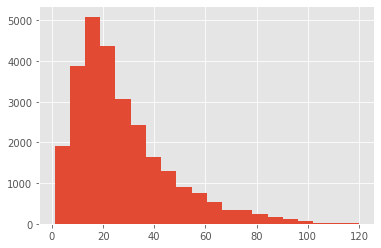

In [40]:
df_cat2["months_since_promotion_last"].hist(bins=20) # 120 months in all (20 bins correspond to 6 month segments)

This chart shows the distribution of the employees across the time to promotion variable. Splitting the data was done based on the annual review cycles (0-12 months, 12-24 months, 24-36 months and 36-120 months). This also has the side benefit of producing roughly equal (with some exception) distributions within each class (shown below).

In [41]:
#splitting the target variable for classification#
cutoffs = [0,12,24,36,120]
labels=[1,2,3,4]

In [42]:
df_cat2["months_since_promotion_last_grp"] = pd.cut(df_cat2["months_since_promotion_last"],bins=cutoffs,labels=labels)
df_cat2=df_cat2.drop("months_since_promotion_last",axis=1)
df_cat2["months_since_promotion_last_grp"].value_counts()

2    9460
4    6454
1    5774
3    5503
Name: months_since_promotion_last_grp, dtype: int64

In [43]:
df_cat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27191 entries, 24 to 93091
Columns: 591 entries, promotion_cnt to months_since_promotion_last_grp
dtypes: category(1), float64(8), int64(42), uint8(540)
memory usage: 24.6 MB


In [44]:
df_cat2["months_since_promotion_last_grp"].dtype

CategoricalDtype(categories=[1, 2, 3, 4], ordered=True)

In [45]:
df_cat2['months_since_promotion_last_grp'] = df_cat2["months_since_promotion_last_grp"].cat.codes # converting to integer otherwise there may be issues with some code later

In [46]:
df_cat2["months_since_promotion_last_grp"].dtype

dtype('int8')

### <i>Final Data Set</i><a class="anchor" id="DP_Final"></a>


As described in the [data processing](#DP_DP) section above, we created two datasets. 

The first dataset used all the available observations (94,108) and was used for the promotion likelihood and contained 591 predictors along with the **promotion_max** target variable. 

The second dataset contains only the promoted employees (27,191 observations) and was used for the prediction of promotion windows; it has 590 variables along with the **months_since_promotion_last_grp** bucket variable (this bucket variable was created based on the value in the **months_since_promotion_last** column). It is important to note that this variable (months_since_promotion_last) was removed from this dataset since we would not want to use that as a predictor for the target variable months_since_promotion_last_grp.

[Back to Table of Contents](#TOC)

# <font color=maroon>Modeling and Evaluation</font><a class="anchor" id="Section3"></a>

### <i>Evaluation Metrics</i><a class="anchor" id="ME_Metrics"></a>



#### Task 1
The company prefers a model that would lean towards overpredicting promotable candidates, versus a smaller pool with fewer options. To that end, we will use recall for the promoted class level as the primary metric. The ultimate goal is to capture 75% of the promoted population.

We do not want to produce a model that will overpredict employee promotability by a large amount. In order to do so, we need to take precision into account along with recall. The best way to do this is to consider use of both the recall and weighted F1 score. The weighted F1 score is the geometric mean of precision and recall. Along with targets of an individual recall (of the promoted class) of 0.75 and weighted F1 score of 0.75, we also have a combined metric (sum of both metrics) that has a target score of 1.50. This is a single score that will be used to compare models.

#### Task 2
For the second task, we have 4 class levels as explained above. For an employee that gets promoted in the 0-1 year bucket, predicting that he/she gets promoted in > 3 years is costlier than predicting that he/she gets promoted in 1-2 years. For this reason, not all cells in the confusion matrix are weighted equally when coming up with a metric to train and evaluate models. To adjust for this, we came up with a custom cost matrix. Since the classes are ordered, predictions that are further away from the actual class are penalized more. We use the square of the difference [**(predicted label - actual label)<sup>2</sup>**] as an aggressive penalty factor. For example:
* If the actual label is 1 and the prediction is 1, the cost is (1-1)<sup>2</sup> = 0. 
* If the actual label is 1 and the prediction is 2, the cost is (2-1)<sup>2</sup> = 1.
* If the actual label is 1 and the prediction is 0, the cost is (0-1)<sup>2</sup> = 1.
* If the actual label is 1 and the prediction is 3, the cost is (3-1)<sup>2</sup> = 4.


In the end, we selected a model (both during grid search and while comparing the 3 different model types) that minimizes the sum of all the cells in this custom cost matrix. 




### <i>Test/Train Split</i><a class="anchor" id="ME_Split"></a>


We decided to perform cross validation during the model building process since we wanted to train multiple models with the same dataset for evaluation. Taking a mean metric across all these models would then give us a better estimate of how well our model is generalizing. We used 3-fold cross validation and chose the final model that gave the best average metric across the 3 folds (highest combination of recall and F1 score for first task and the lowest custom cost for the second task). Also, choosing a model that has a smaller standard deviation for the chosen metric between the folds would mean less overfitting and better generalization. An alternative to visualizing overfitting is to look at the learning curves and compare the train and test errors to see how close or far apart they are. The closer they are, the less overfitting there is.

Another important factor to consider while splitting the data into multiple folds for cross validation was to make sure that the class distribution across the various levels is consistent (roughly equal) across the folds. Hence, stratified folds were needed. We had two options for this in scikit-learn: StratifiedKFold and StratifiedShuffleSplit. 

StratifiedShuffleSplit provided more flexibility since we could choose the number of folds and the percentage of data in train/test independently of each other. This was not possible in StratifiedKFold where the test set size is determined by the number of folds (one of the folds is taken as the test set). Due to this reason, we used StratifiedShuffleSplit for the training process.

We divided our data so that 80% is used for training and 20% is held out for testing. As mentioned above, we used cross validation to separate our split data three times to provide additional opportunities to test our models and minimize the chance of overfitting.

In [47]:
num_cv_iterations = 3

cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,
                         random_state = 101      
                        )

print(cv_object)


StratifiedShuffleSplit(n_splits=3, random_state=101, test_size=0.2,
            train_size=None)


# <font color=maroon>Task 1: Promotion Flag (Classification)</font><a class="anchor" id="Section4"></a>

The classification task is to predict whether an employee will receive a promotion or not. As promotions are high incentives for retention and growth, it is important to identify individuals with high potential at an acceptable accuracy and F1 score. In this task, we are looking into the following models to help us predict employee promotability: Support Vector Machine (SVM), Random Forest, and K-Nearest Neighbors algorithm (KNN).

In [48]:
df_imputed = df.copy(deep=True)
# we want to predict the X and y data as follows:
if 'promotion_max' in df_imputed:
    y = df_imputed['promotion_max'].values # get the labels we want
    del df_imputed['promotion_max'] # get rid of the class label
    X = df_imputed.values # use everything else to predict! 
    dfColNames = df_imputed.columns

[Back to Table of Contents](#TOC)

## <font color=maroon><i>Model One - Support Vector Machine (SVM) </i></font><a class="anchor" id="PF_M1"></a>

In [49]:
# Baseline SVM model
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const
                        ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,n_iter_no_change=iterations
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,random_state=101
                       )

scl_obj = StandardScaler()

confusion matrix
 [[8939 4445]
 [1189 4249]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     13384
           1       0.49      0.78      0.60      5438

    accuracy                           0.70     18822
   macro avg       0.69      0.72      0.68     18822
weighted avg       0.77      0.70      0.71     18822



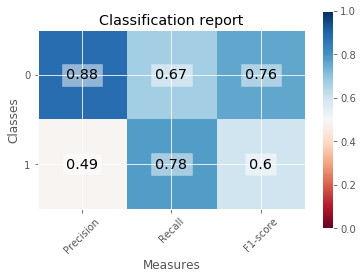

INFO:root: SVM: Iteration 1: Time Taken (seconds): 9.2249224186


confusion matrix
 [[8972 4412]
 [1216 4222]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     13384
           1       0.49      0.78      0.60      5438

    accuracy                           0.70     18822
   macro avg       0.68      0.72      0.68     18822
weighted avg       0.77      0.70      0.71     18822



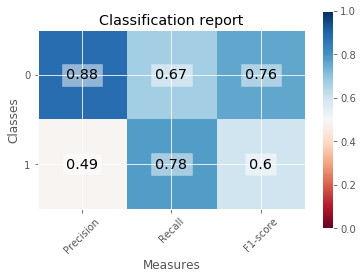

INFO:root: SVM: Iteration 2: Time Taken (seconds): 8.2418239117


confusion matrix
 [[9026 4358]
 [1211 4227]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     13384
           1       0.49      0.78      0.60      5438

    accuracy                           0.70     18822
   macro avg       0.69      0.73      0.68     18822
weighted avg       0.77      0.70      0.72     18822



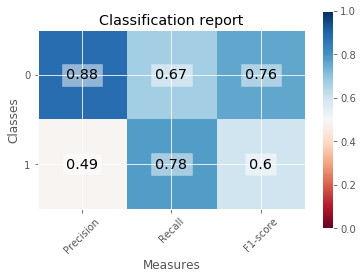

INFO:root: SVM: Iteration 3: Time Taken (seconds): 9.0679068565


In [50]:
train_classifier(estimator=svm_sgd, scl_obj=scl_obj, X=X, y=y, cv=cv_object, verbose=True)

From our analysis above, we see that the baseline SVM model gives a recall score (for the promoted class) of **0.78** and a weighted F1 score of **0.71**. Both these values are close to our original target of 0.75. The combined total score for the baseline model is 0.78 + 0.71 = **1.49**.

The baseline SVM model was created with most parameters set to default values. We decided to weigh the classes according to the class frequencies so that the model does not skew the results towards the "non-promoted" class (which has a higher frequency). SVM with stochastic gradient descent was used to allow the algorithm to converge within a reasonable amount of time.
 

### <i>Parameter Adjustments</i><a class="anchor" id="M1A_PA"></a>


Next, we wanted to see if we could improve this using grid search. We used Bayesian optimization to find the optimal hyperparameters to use. We will discuss this in detail under the ["Exceptional Work"](#Section9) section and explain why we choose this approach over a general grid search approach.

For the Bayesian grid search, the search space was restricted to be within the following space:

- alpha: log-sampled from 1e-5 to 1e0
- max_iter log-sampled from 10e2 to 10e6
- n_iter_no_change: Sampled from 3 to 7

In [51]:
## https://scikit-optimize.github.io/notebooks/visualizing-results.html

# set up hyperparameter space
space = [Real(1e-5, 1e-0, name='alpha', prior='log-uniform')
         ,Real(10e2, 10e6, name='max_iter',prior='log-uniform') # needs an integer but that does not have log-normal sampling. Hence using Real (algorith works with real as well)
         ,Integer(3,7,name='n_iter_no_change')
        ]

# Object to scale the inputs before training
std_scl = StandardScaler()

@use_named_args(space)
def objective(**params):
    svm_sgd = SGDClassifier(learning_rate = 'optimal'
                            ,class_weight = 'balanced'
                            ,loss = 'hinge'
                            ,n_jobs = -1
                            ,random_state = 101
                            ,**params)
    
    piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd)]) # and then do this

    # Define scorers (metrics) to use
    scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

    # Get all metrics and define custom loss function using this data
    cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)
    loss = -np.mean(cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted'])
   
    return (loss)

In [52]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 points total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     ,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.0601
Function value obtained: -1.5046
Current minimum: -1.5046
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 84.0824
Function value obtained: -1.3497
Current minimum: -1.5046
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 30.5641
Function value obtained: -1.5016
Current minimum: -1.5046
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.8000
Function value obtained: -1.4820
Current minimum: -1.5046
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 100.3340
Function value obtained: -1.3866
Current minimum: -1.5046
Iteration No: 6 sta

In [53]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: -1.5045568964247271
Best params:
[0.0057902982820389045, 6467514.810219671, 7]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D44E0B8>,
      dtype=object)

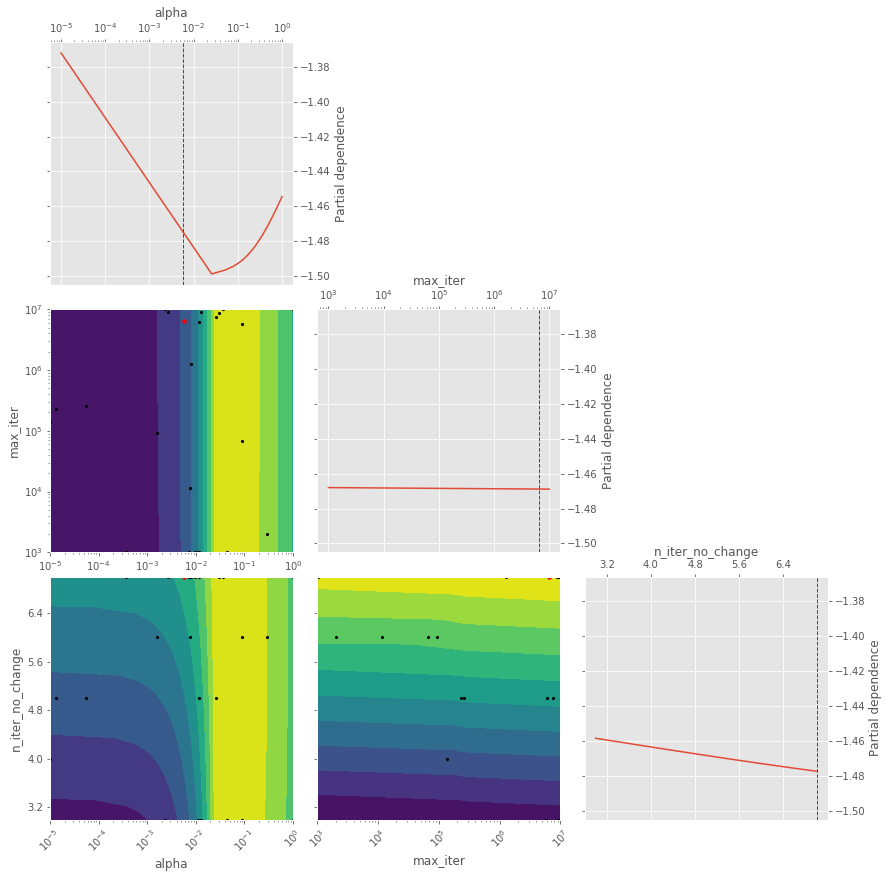

In [54]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['alpha','max_iter','n_iter_no_change'])


The results of the Bayesian hyperparameter optimization provides partial dependence plots showing how the resultant metric changes with each parameter when the other parameters are kept constant. This is a very useful plot to determine which parameter is most impactful in reducing the error in the model. From the partial dependence plots, we can see that for the given hyperparameter search space, max_iter seems to have no impact. There is a minor impact from n_iter_no_change, but the majority of the change is coming from alpha with a clear minima around 1e-1 (based on partial dependence).

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **alpha = 0.0058**, **max_iter = 6467514.81**, and **n_iter_no_change = 7**.

One could argue that since n_iter_no_change lacked a minima and kept decreasing the error, we should have further explored this parameter with a search space beyond 7. This has been left as a follow-up exercise as the resultant gains from this exercise seemed to be minimal from the partial dependence plot.

### <i>Final Model</i><a class="anchor" id="M1A_Final"></a>

In [55]:
# Model with best hyperparameters
svm_sgd = SGDClassifier(alpha = clf_gp.x[0] #0.005790 
                        ,class_weight = 'balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,max_iter=clf_gp.x[1] #6467514.81
                        ,n_iter_no_change= clf_gp.x[2] #7
                        ,n_jobs = -1
                        ,penalty='l2'
                        ,verbose=0
                        ,random_state = 101
                        )

In [56]:
train_classifier(estimator=svm_sgd, scl_obj=scl_obj, X=X, y=y, cv=cv_object)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 11.8071804047


confusion matrix
 [[9215 4169]
 [1217 4221]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     13384
           1       0.50      0.78      0.61      5438

    accuracy                           0.71     18822
   macro avg       0.69      0.73      0.69     18822
weighted avg       0.77      0.71      0.73     18822



INFO:root: SVM: Iteration 2: Time Taken (seconds): 10.5840582848


confusion matrix
 [[9255 4129]
 [1225 4213]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.78     13384
           1       0.51      0.77      0.61      5438

    accuracy                           0.72     18822
   macro avg       0.69      0.73      0.69     18822
weighted avg       0.77      0.72      0.73     18822



INFO:root: SVM: Iteration 3: Time Taken (seconds): 9.9099910259


confusion matrix
 [[9283 4101]
 [1210 4228]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.78     13384
           1       0.51      0.78      0.61      5438

    accuracy                           0.72     18822
   macro avg       0.70      0.74      0.70     18822
weighted avg       0.78      0.72      0.73     18822



### Overall Measure

In [57]:
# Get the overall metrics for the model
piped_object = Pipeline([('scale', std_scl),
                         ('svm_model', svm_sgd)]) # and then do this

scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)

score_tot_svm1 = cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted']
print("Custom Score across the folds")
print(score_tot_svm1)

Custom Score across the folds
[1.50285964 1.50294442 1.50786664]


Running Fold 1
Running Fold 2
Running Fold 3


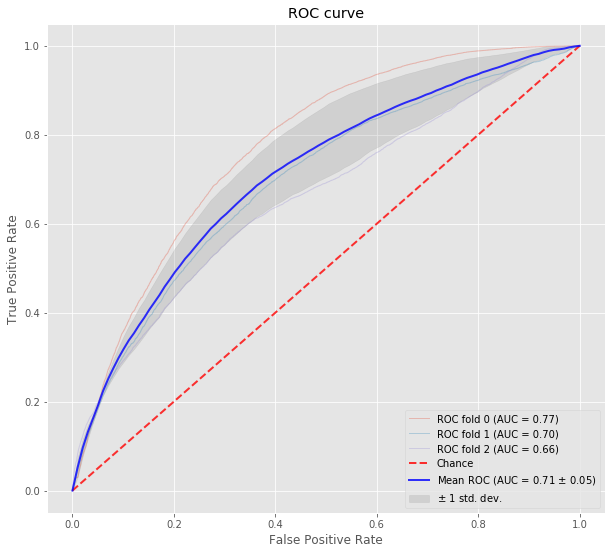

In [58]:
piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd)]) # and then do this
getROC(piped_object,3,X,y,isSVG=True)
#piped_object.fit(X[1:1000], y[1:1000]).decision_function(X[1:1000])

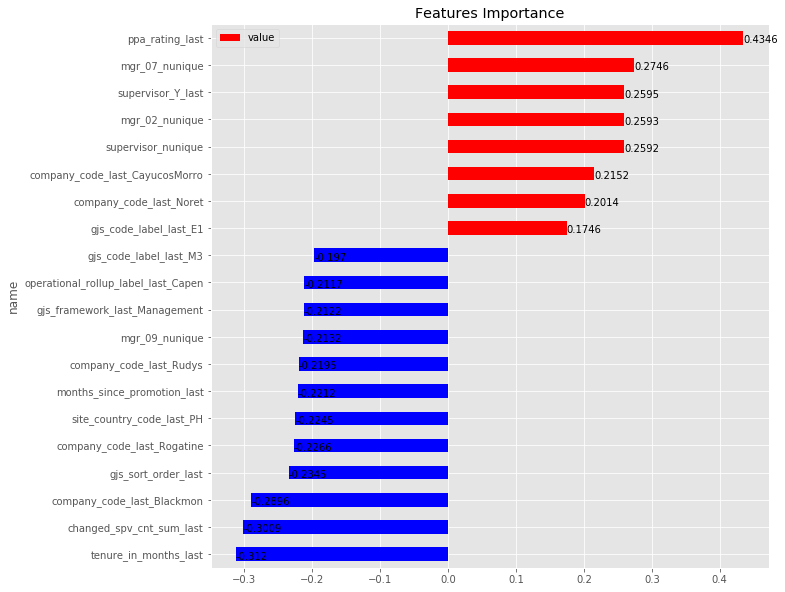

In [59]:
varImpSVM(svm_sgd,20,dfColNames)


The final model that we produced using these parameters produces an average recall for the promoted class of **0.77** and an average weighted F1 score of **0.73** across the 3-folds. This is **practically the same** as the baseline model that we developed in the initial step. The original model was close to optimum, and by finding that we could not improve it using Bayesian grid search, we have greater confidence we have obtained the most optimal model possible. The combined total score for the final model is 0.77 + 0.73 = **1.50**.

The ROC curve for the model shows that the prediction for the test dataset for all the classes has a mean AUC of 0.71 across the 3-folds. This value is above what we would have achieved (AUC = 0.5) with random guessing.

**We can conclude that the SVM model for task 1 barely meets the expectation.**


[Back to Table of Contents](#TOC)

### <font color=maroon><i>Model Two - Random Forest</i></font><a class="anchor" id="PF_M2"></a>

In [60]:
# Baseline Random Forest model
rf_std =RandomForestClassifier( n_estimators=500
                                , max_depth=None
                                , min_samples_split=20
                                , min_samples_leaf=20
                                , n_jobs=-1
                                , class_weight='balanced'
                                , random_state = 101 ) 

confusion matrix
 [[10768  2616]
 [  869  4569]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     13384
           1       0.64      0.84      0.72      5438

    accuracy                           0.81     18822
   macro avg       0.78      0.82      0.79     18822
weighted avg       0.84      0.81      0.82     18822



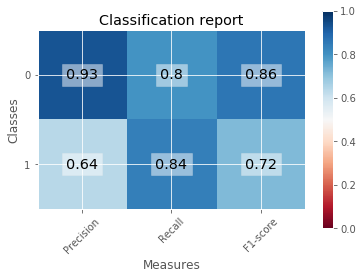

INFO:root: SVM: Iteration 1: Time Taken (seconds): 24.2114210129


confusion matrix
 [[10786  2598]
 [  887  4551]]
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     13384
           1       0.64      0.84      0.72      5438

    accuracy                           0.81     18822
   macro avg       0.78      0.82      0.79     18822
weighted avg       0.84      0.81      0.82     18822



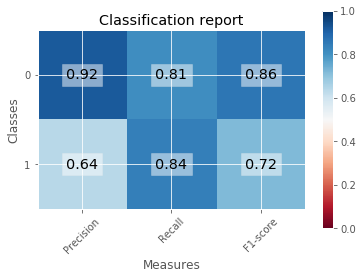

INFO:root: SVM: Iteration 2: Time Taken (seconds): 24.2324228287


confusion matrix
 [[10822  2562]
 [  872  4566]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86     13384
           1       0.64      0.84      0.73      5438

    accuracy                           0.82     18822
   macro avg       0.78      0.82      0.79     18822
weighted avg       0.84      0.82      0.82     18822



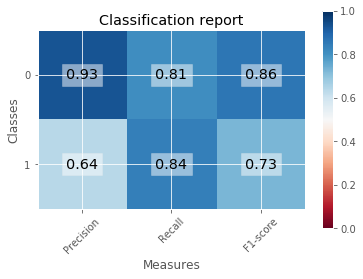

INFO:root: SVM: Iteration 3: Time Taken (seconds): 24.7234721184


In [61]:
train_classifier(estimator=rf_std, X=X, y=y, cv=cv_object,verbose=True)


From our analysis above, we see that the baseline Random Forest model gives a recall score (for the promoted class) of **0.84** and a weighted F1 score of **0.82**. Both these values are exceeding  our original target of **0.75**.  The combined total score for the baseline model is 0.84 + 0.82 = **1.66**.

The baseline Random Forest was created with most parameters set to default values (min_sample_split = 30, min_sample_leaf = 20, and n_estimators = 500). We decided to weigh the classes according to the class frequencies so that the model does not skew the results towards the "non-promoted" class (which has a higher frequency). Random forest with 'balanced' mode allows to use the values of y to automatically adjust weights inversely proportional to the class frequencies in the input data.


### <i>Parameter Adjustments</i><a class="anchor" id="M2A_PA"></a>

Similar to SVM, we wanted to see if we could improve the base Random Forest model using Bayesian optimization based grid search. For the Bayesian grid search, the search space was restricted to be within the following space.

For the Bayesian grid search, the search space was restricted to be within the following space:

- n_estimators: sampled from 100 to 1000
- max_depth: sampled from 10 to 1000
- min_samples_split: log-sampled from 1e-6 to 0.1
- min_samples_leaf: log-sampled from 1e-6 to 0.1

In [62]:
# set up hyperparameter space
space = [Integer(100, 1000, name='n_estimators')#, prior='log-uniform')
         ,Integer(10, 1000, name='max_depth')#, prior='log-uniform')
         ,Real(0.000001, 0.1, name='min_samples_split', prior='log-uniform')
         ,Real(0.000001, 0.1, name='min_samples_leaf', prior='log-uniform')
        ]

@use_named_args(space)
def objective(**params):
    rf_std =RandomForestClassifier( n_jobs=-1
                                    , random_state = 101 
                                   , class_weight='balanced'
                                     ,**params)
    
    piped_object = Pipeline([('rf_model', rf_std)])  

    # Define scorers (metrics) to use
    scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

    # Get all metrics and define custom loss function using this data
    cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)
    loss = -np.mean(cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted'])
   
    return (loss)

In [63]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 points total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     ,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 59.4089
Function value obtained: -1.5014
Current minimum: -1.5014
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 92.0392
Function value obtained: -1.6812
Current minimum: -1.6812
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 70.2920
Function value obtained: -1.4849
Current minimum: -1.6812
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 25.9026
Function value obtained: -1.6278
Current minimum: -1.6812
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 44.6945
Function value obtained: -1.4314
Current minimum: -1.6812
Iteration No: 6 star

In [64]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: -1.6830239805748393
Best params:
[1000, 990, 0.0004902716526035608, 1.1522949033544193e-06]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D480D68>,
      dtype=object)

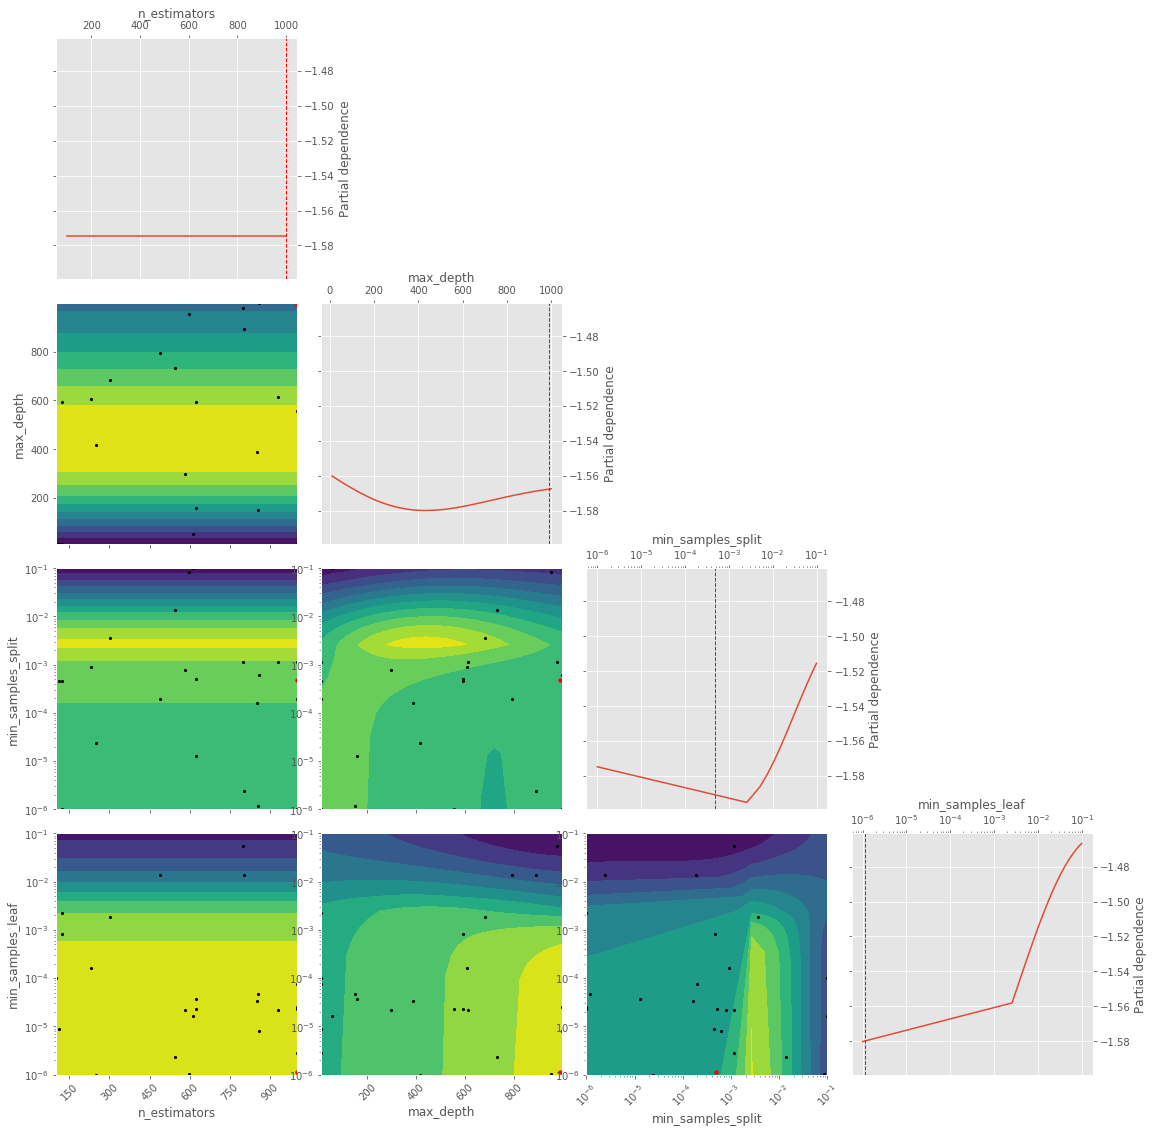

In [65]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['n_estimators','max_depth','min_samples_split','min_samples_leaf'])


From the partial dependence plots, we can see that for the given hyperparameter search space, n_estimator seems to have no impact on the model's metric. There is a minor impact from max_depth, but the majority of the change is coming from min_samples_split with a clear minima around 1e-3 (based on partial dependence). Min_samples_leaf has also strong impact to the model with a minima on 1e-6. We could have run the grid with a lower value for min_samples_leaf, but 1e-6 already represent a leaf with less than 8 elements, so further reduction would not be beneficial for the model performance.

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **n_estimators = 1000**, **max_depth = 990**, **min_samples_split = 0.00049027**, and **min_samples_leaf = 1.1522e-6**.


### <i>Final Model</i><a class="anchor" id="M2A_Final"></a>

In [66]:

rf_std = RandomForestClassifier( n_jobs=-1
                                , random_state = 101 
                                , n_estimators = clf_gp.x[0] #1000 
                                , max_depth = clf_gp.x[1] #990 
                                , min_samples_split =  clf_gp.x[2] # 0.0004902716526035608 
                                , min_samples_leaf =clf_gp.x[3]  # 1.1522949033544193e-06 
                                , class_weight='balanced'
                               )   

confusion matrix
 [[11586  1798]
 [  918  4520]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     13384
           1       0.72      0.83      0.77      5438

    accuracy                           0.86     18822
   macro avg       0.82      0.85      0.83     18822
weighted avg       0.87      0.86      0.86     18822



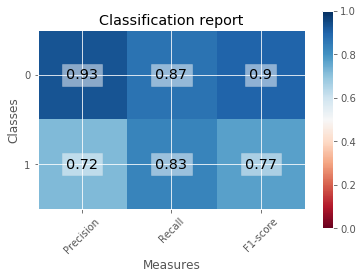

INFO:root: SVM: Iteration 1: Time Taken (seconds): 46.4457235336


confusion matrix
 [[11550  1834]
 [  954  4484]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     13384
           1       0.71      0.82      0.76      5438

    accuracy                           0.85     18822
   macro avg       0.82      0.84      0.83     18822
weighted avg       0.86      0.85      0.85     18822



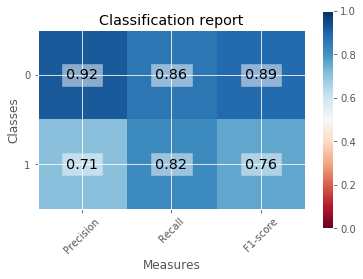

INFO:root: SVM: Iteration 2: Time Taken (seconds): 46.2684111595


confusion matrix
 [[11590  1794]
 [  961  4477]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     13384
           1       0.71      0.82      0.76      5438

    accuracy                           0.85     18822
   macro avg       0.82      0.84      0.83     18822
weighted avg       0.86      0.85      0.86     18822



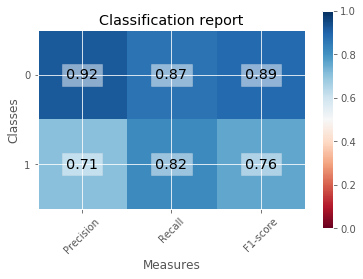

INFO:root: SVM: Iteration 3: Time Taken (seconds): 47.4459965229


In [67]:
train_classifier(estimator=rf_std, X=X, y=y, cv=cv_object, verbose=True)

### Overall Measure

In [68]:
# Get the overall metrics for the model
piped_object = Pipeline([('rf_model', rf_std)])  

scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)

score_tot_rf1 = cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted']
print("Custom Score across the folds")
print(score_tot_rf1)

Custom Score across the folds
[1.68983695 1.67946971 1.67976528]


Running Fold 1
Running Fold 2
Running Fold 3


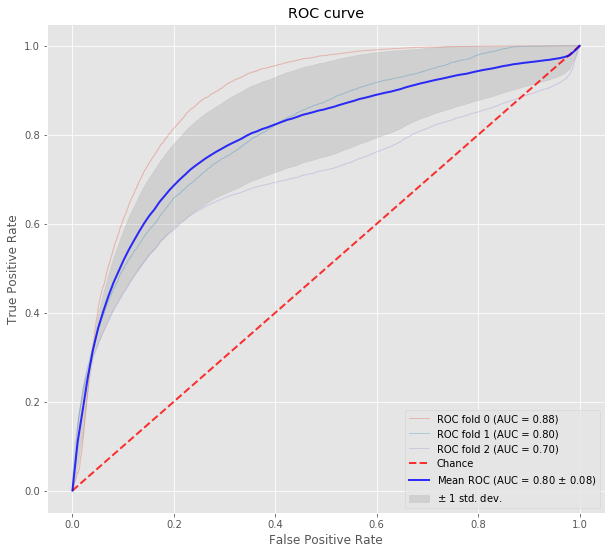

In [69]:
getROC(rf_std,3,X,y)

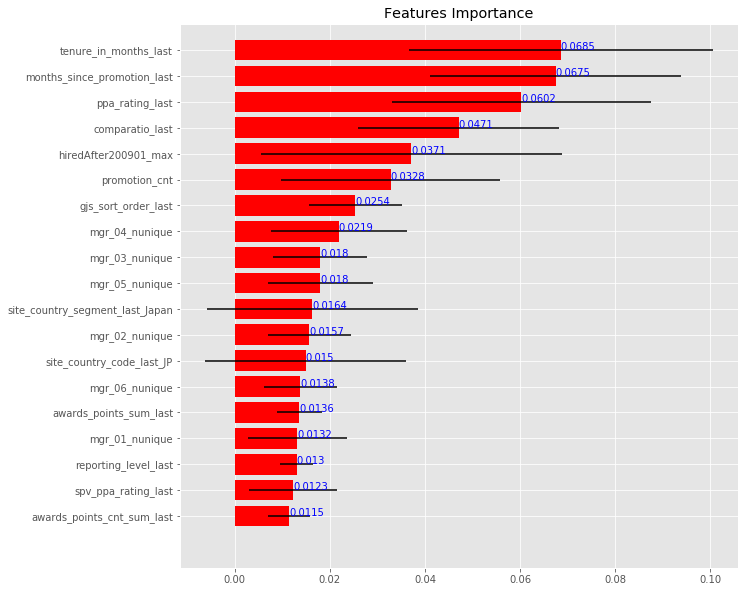

In [70]:
#skplt.estimators.plot_feature_importances(rf_std,feature_names=dfColNames,x_tick_rotation=90,figsize=[5,10])
varImpRFStDev(rf_std,20,dfColNames)


The final model that we produced using these parameters produces an average recall for the promoted class of **0.83** and an average weighted F1 score of **0.86** across the 3-folds. This is **slightly higher** than the baseline Random Forest model that we developed in the initial step.  The combined total score for the final model is 0.86 + 0.83 = **1.69**.

The ROC curve for the model shows that the prediction for the test dataset for all the classes has a mean AUC of 0.80 across the 3-folds. This value is above what we would have achieved (AUC = 0.5) with random guessing. 

**We can conclude that the Random Forest model for task 1 exceeds the target measures.**

[Back to Table of Contents](#TOC)

### <font color=maroon><i>Model Three - k-Nearest Neighbors (KNN) </i></font><a class="anchor" id="PF_M3"></a>

In [71]:
# Baseline KNN Model
knn_std = KNeighborsClassifier(n_neighbors=3
                              ,weights='uniform'
                              ,algorithm ='auto'
                              ,p=2 #euclidian distance
                              ,n_jobs=-1
                              )  

confusion matrix
 [[11789  1595]
 [ 2256  3182]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     13384
           1       0.67      0.59      0.62      5438

    accuracy                           0.80     18822
   macro avg       0.75      0.73      0.74     18822
weighted avg       0.79      0.80      0.79     18822



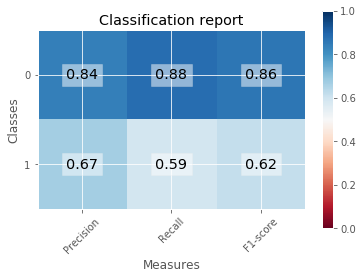

INFO:root: SVM: Iteration 1: Time Taken (seconds): 167.679901123


confusion matrix
 [[11833  1551]
 [ 2280  3158]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     13384
           1       0.67      0.58      0.62      5438

    accuracy                           0.80     18822
   macro avg       0.75      0.73      0.74     18822
weighted avg       0.79      0.80      0.79     18822



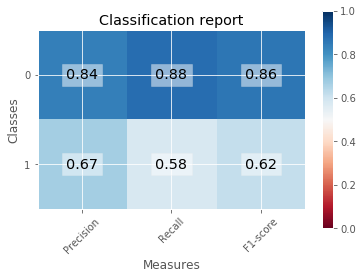

INFO:root: SVM: Iteration 2: Time Taken (seconds): 175.483230114


confusion matrix
 [[11853  1531]
 [ 2322  3116]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     13384
           1       0.67      0.57      0.62      5438

    accuracy                           0.80     18822
   macro avg       0.75      0.73      0.74     18822
weighted avg       0.79      0.80      0.79     18822



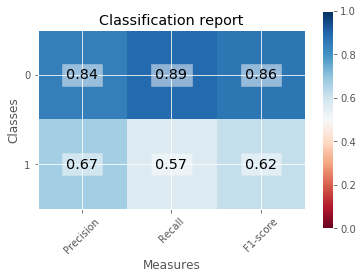

INFO:root: SVM: Iteration 3: Time Taken (seconds): 175.4754507542


In [72]:
train_classifier(estimator=knn_std, scl_obj=scl_obj, X=X, y=y, cv=cv_object,verbose=True)

From our analysis above, we see that the baseline k-Nearest Neighbors model gives a recall score (for the promoted class) of **0.59** and a weighted F1 score of **0.79**. The recall score doesn't meet our target of 0.75. The combined total score for the baseline model is 0.59 + 0.79 = **1.38**.

The baseline KNN was created with most parameters set to default values. We decided to weigh the classes according to the class distances so that closer neighbors have greater influence over predictions. The KDTree algorithm was used to quickly generalize the number of points.

### <i>Parameter Adjustments</i><a class="anchor" id="M3A_PA"></a>

Similar to previous models, we wanted to see if we could improve the base KNN model using Bayesian optimization based grid search. For the Bayesian grid search, the search space was restricted to be within the following space:

- n_neighbors: sampled from 1 to 100
- p: sampled from 1 to 2
- leaf_size: sampled from 1 to 60

In [73]:
# set up hyperparameter space
space = [Integer(1, 100, name='n_neighbors')#, prior='log-uniform')
         ,Integer(1, 2, name='p')#, prior='log-uniform')
         ,Integer(1,60,name='leaf_size')
        ]

# Object to scale the inputs before training
std_scl = StandardScaler(with_mean=True,with_std=True)

@use_named_args(space)
def objective(**params):
    knn_std = KNeighborsClassifier(n_jobs=-1
                                   ,weights='distance'
                                   ,algorithm='kd_tree'
                                   ,**params)
    
    piped_object = Pipeline([('scale', std_scl),  
                             ('knn_model', knn_std)])  

    # Define scorers (metrics) to use
    scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

    # Get all metrics and define custom loss function using this data
    cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)
    loss = -np.mean(cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted'])
   
    return (loss)

In [74]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 points total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     ,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1176.8101
Function value obtained: -1.1731
Current minimum: -1.1731
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 742.7360
Function value obtained: -1.3940
Current minimum: -1.3940
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1204.5280
Function value obtained: -1.2444
Current minimum: -1.3940
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1243.9100
Function value obtained: -1.1897
Current minimum: -1.3940
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 929.7660
Function value obtained: -1.3848
Current minimum: -1.3940
Iteration No

c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 979.1220
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 14 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1155.1010
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1136.0250
Function value obtained: -1.3917
Current minimum: -1.4221
Iteration No: 16 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 962.2600
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 985.9500
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 18 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 963.7250
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 991.3120
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 20 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 983.1200
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 21 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 993.5700
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1079.7260
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 23 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1107.4210
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 997.8940
Function value obtained: -1.4221
Current minimum: -1.4221
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 975.3000
Function value obtained: -1.4221
Current minimum: -1.4221


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F667438>,
      dtype=object)

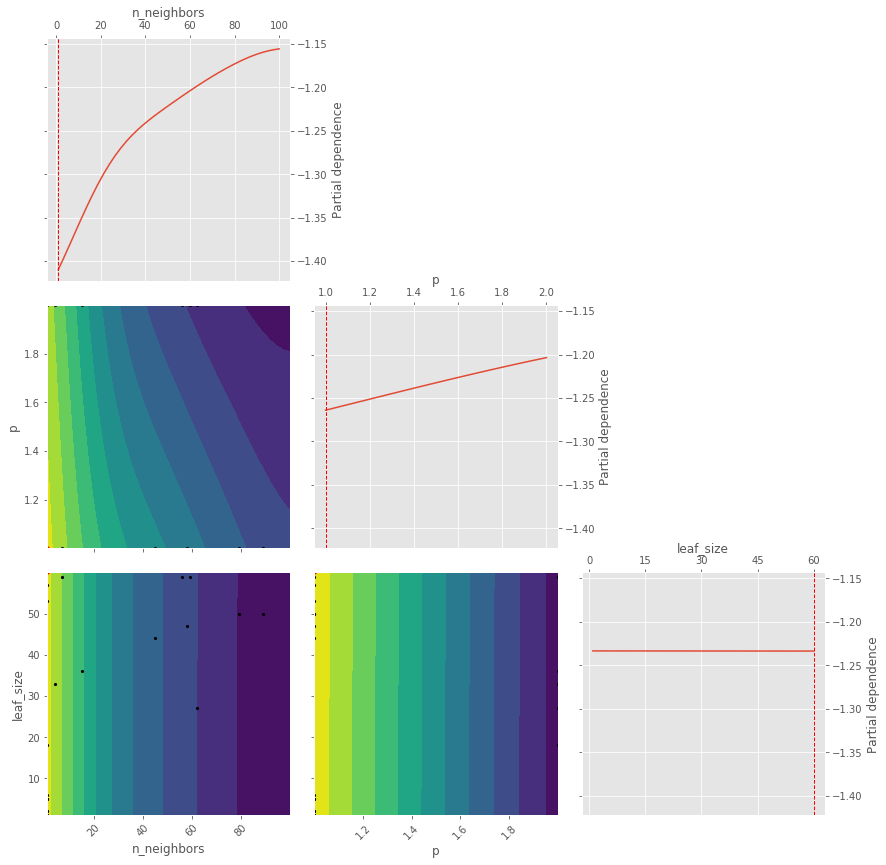

In [75]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['n_neighbors','p','leaf_size'])

In [76]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: -1.422108647015247
Best params:
[1, 1, 60]


From the partial dependence plots, we can see that for the given hyperparameter search space, leaf_size seems to have no impact. There is a minor impact from p, but the majority of the change is coming from n_neighbors, which is continuously rising.

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **n_neighbors = 1**, **p = 1** and **leaf_size = 60**. 

### <i>Final Model</i><a class="anchor" id="M3A_Final"></a>

confusion matrix
 [[11651  1733]
 [ 2056  3382]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     13384
           1       0.66      0.62      0.64      5438

    accuracy                           0.80     18822
   macro avg       0.76      0.75      0.75     18822
weighted avg       0.80      0.80      0.80     18822



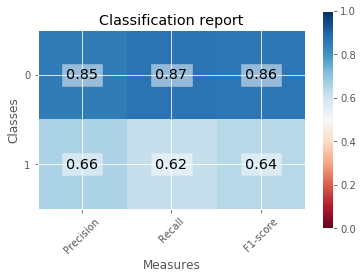

INFO:root: SVM: Iteration 1: Time Taken (seconds): 200.0199999809


confusion matrix
 [[11750  1634]
 [ 2052  3386]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     13384
           1       0.67      0.62      0.65      5438

    accuracy                           0.80     18822
   macro avg       0.76      0.75      0.76     18822
weighted avg       0.80      0.80      0.80     18822



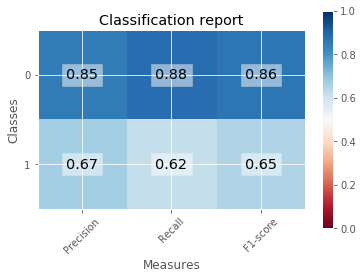

INFO:root: SVM: Iteration 2: Time Taken (seconds): 198.0700001717


confusion matrix
 [[11760  1624]
 [ 2059  3379]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     13384
           1       0.68      0.62      0.65      5438

    accuracy                           0.80     18822
   macro avg       0.76      0.75      0.76     18822
weighted avg       0.80      0.80      0.80     18822



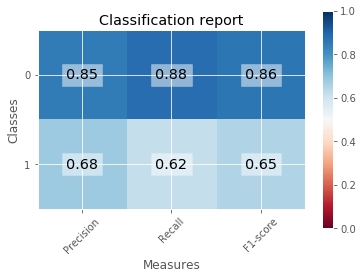

INFO:root: SVM: Iteration 3: Time Taken (seconds): 199.5110001564


In [77]:
knn_std = KNeighborsClassifier(n_neighbors=1 #clf_gp.x[0] #1
                              , p=1 #clf_gp.x[1] #1 
                              , weights='distance'
                              , algorithm ='kd_tree'
                              , leaf_size=60 #clf_gp.x[2] #60
                              , n_jobs=-1
                              ) 
   
train_classifier(estimator=knn_std, scl_obj=std_scl, X=X, y=y, cv=cv_object,verbose=True)

### Overall Measure

In [78]:
# Get the overall metrics for the model
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('knn_model', knn_std)]) # and then do this

scoring = {'recall_promoted_only': make_scorer(recall_score, average='binary') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
              }

cv_results = cross_validate(piped_object, X, y, cv=cv_object, scoring = scoring)

score_tot_knn1 = cv_results['test_recall_promoted_only'] + cv_results['test_f1_weighted']
print("Custom Score across the folds")
print(score_tot_knn1)

Custom Score across the folds
[1.41873217 1.42441256 1.42318121]


Running Fold 1
Running Fold 2
Running Fold 3


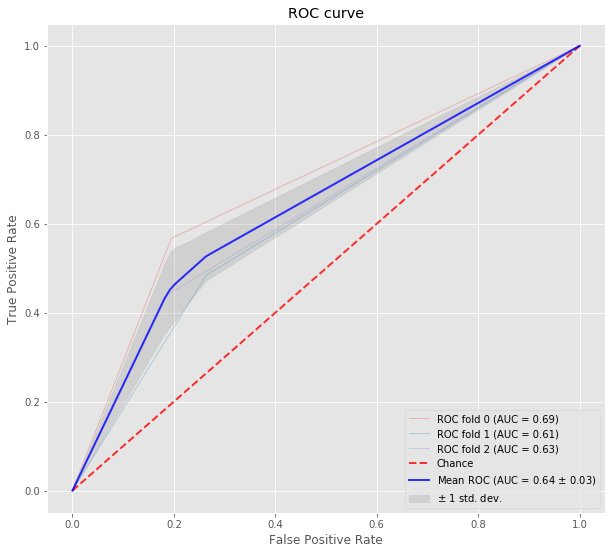

In [79]:
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('knn_model', knn_std)]) # and then do this
getROC(piped_object,3,X,y)

..........

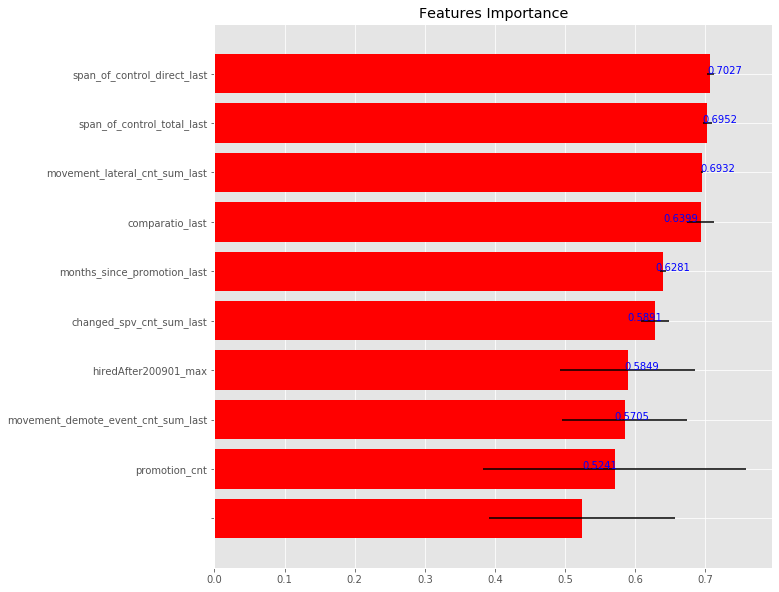

In [80]:
VarImpKNN(knn_std,X,y,dfColNames,cv_object,10,10)


To obtain the feature importance for KNN, we had to create a separate model for the target variable with each feature taken one at a time. The resulting model accuracy was used as a surrogate for the feature importance. Since we had over 500 features, this would have resulted in over 500 KNN models and as each KNN training step is very time consuming, this would have taken a long time. 

Since the KNN model did not give very good results compared to SVM and Random Forest, we are just showing this process for 10 features as an exercise but we will rely on the feature importance from SVM and Random Forest instead to draw any insights.

The final model that we produced using these parameters produces an average recall for the promoted class of **0.62** and an average weighted F1 score of **0.80** across the 3-folds. This is **slightly higher** than the baseline KNN model that we developed in the initial step. The combined total score for the final model is 0.62 + 0.80 = **1.42**.

The ROC curve for the model shows that the prediction for the test dataset for all the classes has a mean AUC of 0.64 across the 3-folds. Although this value is above what we would have achieved (AUC = 0.5) with random guessing, it is not as high as what we got from the SVM and Random Forest models. 

**We can conclude that the KNN model for task 1 does not exceed the target measures.**

[Back to Table of Contents](#TOC)

# <font color=maroon>Model Analysis</font><a class="anchor" id="PF_MA"></a>

Since we are running multiple models and each model has multiple folds, it can be difficult to compare and chose the best one based on a defined metric. A boxplot visualization will he helpful to someone using these models since it will visually compare the performance of models and provide key pieces of information.

For example, for a single model, if there is a large variation in the metric for each fold (as indicated by a wider boxplot), it could be indicative of the model overfitting.

Secondly, without doing a statistical test, if there is no overlap between the boxplots of 2 models, we can say that one is performing better than the other. If there is overlap however, visual comparisons may not be robust and we will need to perform a statistical test to make a conclusion on which model is performing better (if at all).

Text(0.5, 1.0, '')

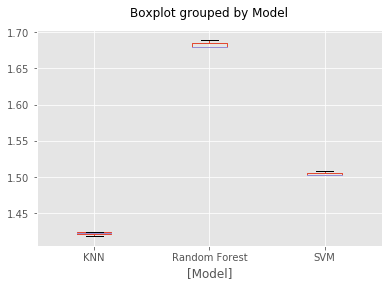

In [81]:
task1_scores = pd.DataFrame(data={'Model':'SVM','Score':score_tot_svm1}).append(
                        [pd.DataFrame(data={'Model':'Random Forest','Score':score_tot_rf1})
                         ,pd.DataFrame(data={'Model':'KNN','Score':score_tot_knn1})
                        ])

#plt.boxplot()
task1_scores.boxplot(by='Model')
plt.title('')

The boxplot visualization above shows that the **Random Forest** model has the highest custom score and we see no visual overlap with the custom scores of other models. 

In [82]:
task1_scores.groupby('Model').agg(['mean','std'])

Score          
                   mean       std
Model                            
KNN            1.422109  0.002988
Random Forest  1.683024  0.005902
SVM            1.504557  0.002867


The table above shows that the scores for all three models have very small standard deviations and very different means. Having small standard deviation between the different folds indicates the models are not overfitting.

Next we will do a statistical comparison of the scores to quantify the difference in the performance of the models.

[Back to Table of Contents](#TOC)

# <font color=maroon>Model Comparison</font><a class="anchor" id="PF_MC"></a>

#### Statistical Difference between Models

In [83]:
print("Statistical Difference between Random Forest and SVM:")
compare_models(score_tot_rf1,score_tot_svm1)

print("\nStatistical Difference between Random Forest and KNN:")
compare_models(score_tot_rf1,score_tot_knn1)

print("\nStatistical Difference between SVM and KNN:")
compare_models(score_tot_svm1,score_tot_knn1)

Statistical Difference between Random Forest and SVM:
Range of difference = 0.1628 to 0.19413

Statistical Difference between Random Forest and KNN:
Range of difference = 0.24295 to 0.27888

Statistical Difference between SVM and KNN:
Range of difference = 0.07555 to 0.08935



The statistical comparison section above uses a t-test to compare the scores of all models. With a 95% confidence interval, we can reject the null hypothesis that the models have the same custom scores.


For comparing the models from task 1, we chose a custom score calculated as the sum of the weighted F1 and recall (for the target class) measures. We selected the model with the highest optimized custom score. 

The Random Forest model outperformed SVM and KNN based on our evaluation metrics of Recall and Weighted F1 for identifying candidates for promotion.


| Model        | SVM      | Random Forest   |    KNN       |
|:------------:|:--------:|:---------------:|:------------:|
|Recall        |   0.77   |<b>   0.83   </b>|     0.62     |
|Weighted F1   |   0.73   |<b>   0.86   </b>|     0.80     |
|Custom (Total) Score   |   1.50   |<b>   1.69   </b>|     1.42     |

### <i>Advantages of Models</i><a class="anchor" id="PF_Results"></a>

Since promotion is based on a culmination of factors that have a plethora of combinations, it makes sense that Random Forest would perform strongly here. Also, for KNN, the sparse feature space (for cases that have lots of features) limits the proximity of the nearest neighbors, and for this reason KNN may not make predictions well. Indeed, this is what we have seen here as KNN was the worst performing model. Likewise, since individuals may overlap in many areas with differing promotion outcomes, a linear separation via SVM may be difficult to do. 

The summary of the results from the models reported above shows also that **Random Forest** has both recall and weighted F1 scores well above our target goal of 0.75, so we conclude that this model yielded the highest performance between all three models.


[Back to Table of Contents](#TOC)

# <font color=maroon>Important Attributes</font><a class="anchor" id="PF_IA"></a>

Since Random Forest was the best performing model  we will use this model to analyze the feature importance.

Under the Random Forest classification, we see the following set of important attributes: tenure_in_months_last, comparatio_last, and ppa_rating_last. Both tenure and comparatio make sense as important features as a longer tenure dampens promotion likelihood while a higher compensation may result in more responsibilities (a detail that may lead to promotions).  

All feature importance values are < 0.1. The fact that no one variable had a very high feature importance points to the fact that there are many factors that can impact promotion and there was no standout feature that can be used alone to predict promotion.  


###  <font color=blue>Theme 1 - Performance </font> <a class="anchor" id="LRM_T1"></a>


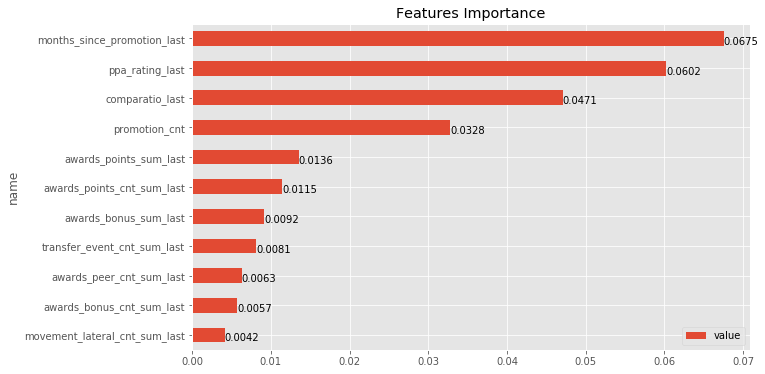

In [84]:
varImpRF(rf_std,20,dfColNames,rating_related,figsize=[10,6])


**Observations:**

- The three highest features under the performance theme by scalar weight are months_since_promotion_last, ppa_rating_last, and comparatio_last.
- Of the three, months_since_promotion_last has the largest weight and stands as one of the largest weights within our Random Forest model. Realistically, this makes sense – an employee’s performance rating and time since previous promotion likely have a large influence on their promotability, validated by these weights.
- The features transfer_event_cnt_sum_last and awards_bonus_cnt_sum_last have a mild positive influence. Logically, this makes sense as the longer an employee remains in one job, the less likely that employee will see vertical movement. Likewise, a higher awards count can be a gateway to promotion events. 

###  <font color=blue>Theme 2 - Supervision Status </font> <a class="anchor" id="LRM_T2"></a>


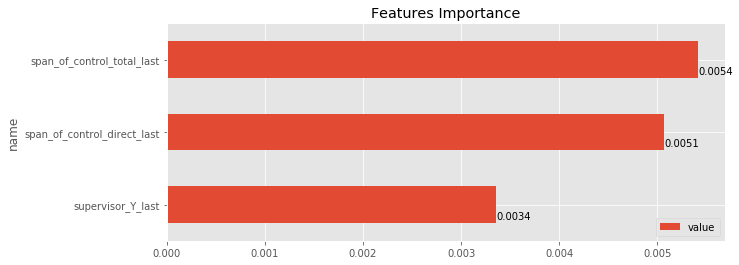

In [85]:
varImpRF(rf_std,20,dfColNames,supervision_related,figsize=[10,4])


**Observations:**
- Although there are not many features that fall under this theme, it appears that of all the features, the most influential by the number of direct and indirect reporting to an employee. The variable importance measure in the Random Forest model doesn't provide directionality, so we cannot derive if the highest number of reports is tied to highest promotability.

###  <font color=blue>Theme 3 - Regional </font><a class="anchor" id="LRM_T3"></a>


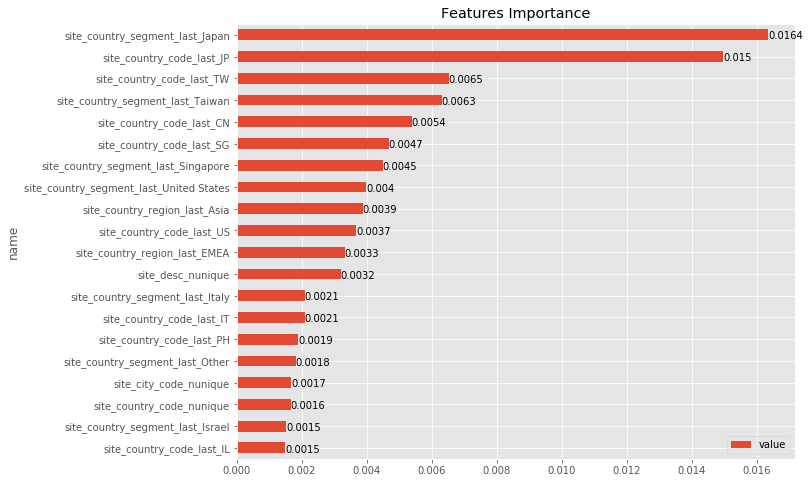

In [86]:
varImpRF(rf_std,20,dfColNames,region_related,figsize=[10,8])


**Observations:**
- Here, the features site_country_segment_japan and site_country_code_last_JP are outstanding. Interestingly these two metrics are consistent with each other. The Japan country segment only contains Japan, and working in Japan is meaningful to one's career. As we don't have directionality information we do not know whether or not Japanese workers are highly promotable.


###  <font color=blue>Theme 4 - Manager</font> <a class="anchor" id="LRM_T4"></a>

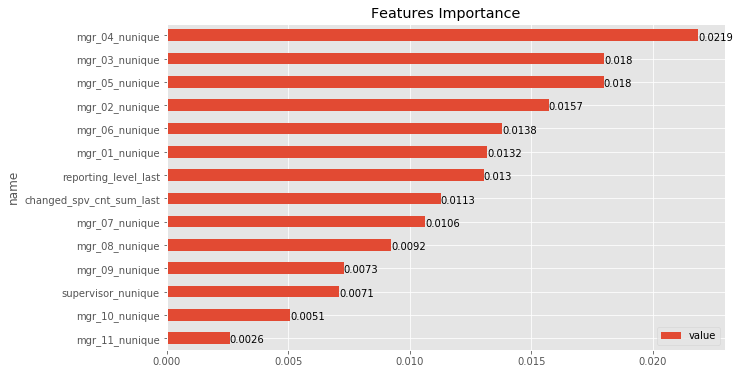

In [87]:
varImpRF(rf_std,20,dfColNames,manager_related,figsize=[10,6])


**Observations:**
- It is noticeable that the number of mid to upper level managers strongly impact the promotion likelihood. We know from the exploratory data analysis that these variables were highly correlated, and because of multicollinearity the weights for these variables can be influenced by each other. Hence, we cannot conclude any causation based on these weights alone.
- The number of supervisors also has a moderate influence on promotability (changed_spv_cnt_sum_last). 

###  <font color=blue>Theme 5 - Functional Area </font> <a class="anchor" id="LRM_T5"></a>

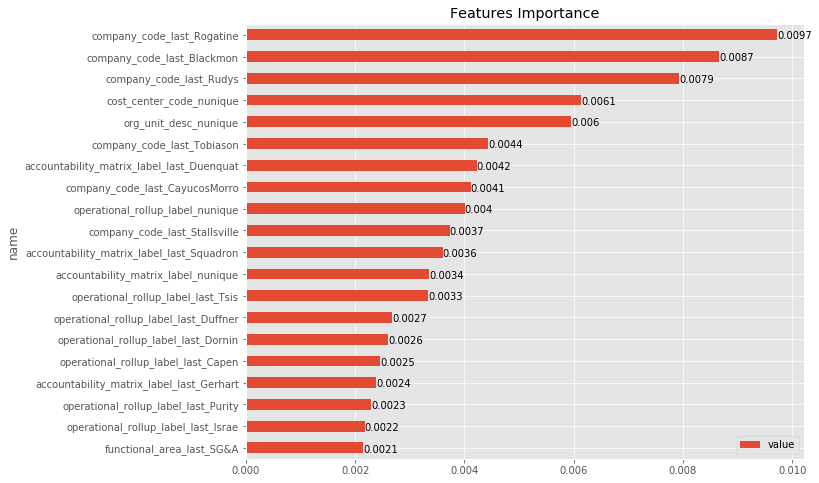

In [88]:
varImpRF(rf_std,20,dfColNames,func_area_related,figsize=[10,8])


**Observations:**
- Some companies have significant influence over promotability (namely Rogatine, Blackmon, and Rudys). 
- The functional area SG&A has a lower influence on the promotion likelihood.

###  <font color=blue>Theme 6 - Job Grade </font> <a class="anchor" id="LRM_T6"></a>


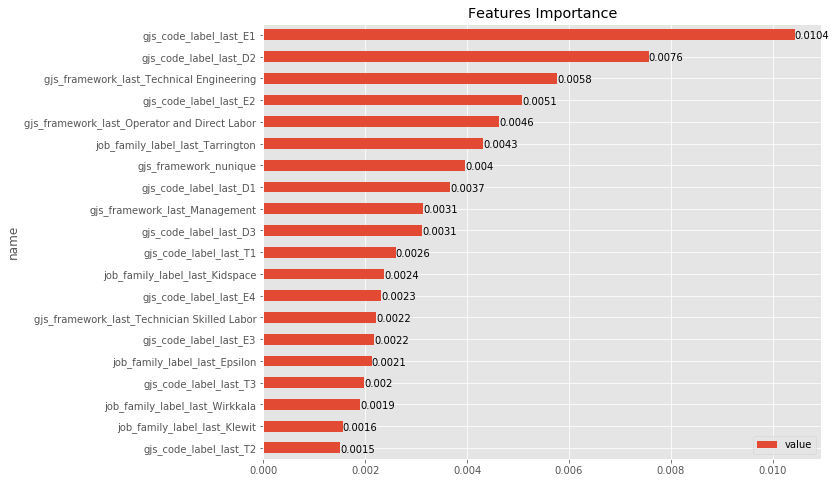

In [89]:
varImpRF(rf_std,20,dfColNames,job_grade_related,figsize=[10,8])


**Observations:**
- Various gjs_code_label_last values have differing impact on promotability, perhaps indicative of dead-end roles or peak career levels (like the E4 one). Junior Roles have higher impact on the promotability, like E1, D2, and E2. This make sense as company guidelines dictate that employees in these roles are expected to step to the next level within a defined timeframe.



###  <font color=blue>Theme 7 - Tenure </font> <a class="anchor" id="LRM_T7"></a>


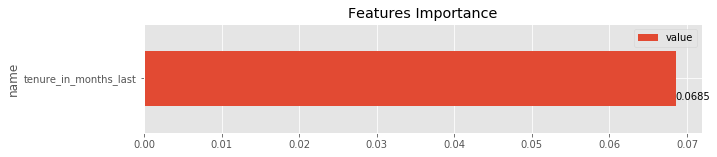

In [90]:
varImpRF(rf_std,20,dfColNames,tenure_related,figsize=[10,2])


**Observations:**
- Tenure has a large impact on promotability compared to all other factors. Logically, this makes sense as this is correlated with career stagnation. 

###  <font color=blue>Theme 8 - Education </font> <a class="anchor" id="LRM_T8"></a>


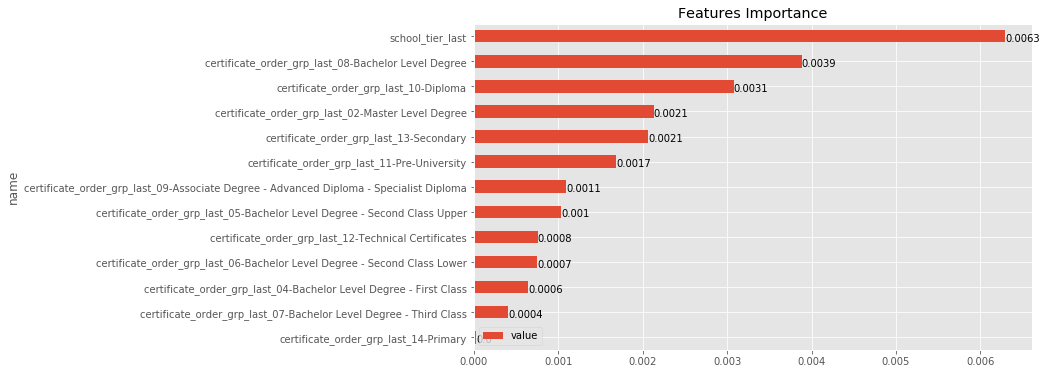

In [91]:
varImpRF(rf_std,20,dfColNames,education_related,figsize=[10,6])


**Observations:**
- The school tier has strong impact on the promotability, as well as bachelor, master, and diploma degrees. This is consistent with the company business objective revolving around innovation and technology. 
- Primary, first, and second class degrees have much lower impact on the promotability, also in line with the previous point.
- We know from the exploratory data analysis that school tier is highly correlated with higher degree, and because of multicollinearity the weights for these variables can be influenced by each other. Hence, we cannot conclude any causation based on these weights alone.
<br>

[Back to Table of Contents](#TOC)

# <font color=maroon>Task 2: Estimated Months Since Promotion (Classification)</font><a class="anchor" id="Section5"></a>


The classification task here is an extension of the previous promotion flag classification. Only employees who have been promoted will be used for this task. Promotions are most often given annually, and therefore we will predict the likelihood of an employee receiving a promotion one, two, and three years since promotion. As such, our data is grouped by the following month intervals: (0, 12], (12, 24], (24, 36], and (36, 120]. This classification will predict which employees have high, medium, low, or minimal priority within the organization. 


#### Preparing Target and Feature Variables

In [92]:
df_imputed2 = df_cat2.copy(deep=True)

# we want to predict the X and y data as follows:
if 'months_since_promotion_last_grp' in df_imputed2:
    y2 = df_imputed2['months_since_promotion_last_grp'].values # get the labels we want
    del df_imputed2['months_since_promotion_last_grp'] # get rid of the class label
    X2 = df_imputed2.values # use everything else to predict!
    df2ColNames = df_imputed2.columns


### <font color=maroon><i>Model One - SVM</i></font><a class="anchor" id="EM_M1"></a>

In [93]:
# Baseline SVM Model

regularize_const = 0.1
iterations = 5
svm_sgd2 = SGDClassifier(alpha=regularize_const
                        ,class_weight='balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,n_iter_no_change=iterations
                        ,n_jobs=-1
                        ,penalty='l2'
                        ,random_state=101
                       )

scl_obj = StandardScaler()

In [94]:
train_classifier(estimator=svm_sgd2, scl_obj=scl_obj, X=X2, y=y2, cv=cv_object, verbose=False)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 2.3219997883


confusion matrix
 [[ 895  191   58   11]
 [ 464 1034  244  150]
 [  48  357  225  471]
 [  11   61   32 1187]]
              precision    recall  f1-score   support

           0       0.63      0.77      0.70      1155
           1       0.63      0.55      0.59      1892
           2       0.40      0.20      0.27      1101
           3       0.65      0.92      0.76      1291

    accuracy                           0.61      5439
   macro avg       0.58      0.61      0.58      5439
weighted avg       0.59      0.61      0.59      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 2.6139998436


confusion matrix
 [[ 894  203   42   16]
 [ 475 1011  232  174]
 [  65  358  181  497]
 [   7   45   41 1198]]
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      1155
           1       0.63      0.53      0.58      1892
           2       0.36      0.16      0.23      1101
           3       0.64      0.93      0.75      1291

    accuracy                           0.60      5439
   macro avg       0.56      0.60      0.56      5439
weighted avg       0.57      0.60      0.57      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 2.5130002499


confusion matrix
 [[ 908  188   48   11]
 [ 575  922  261  134]
 [  66  373  216  446]
 [  13   73   37 1168]]
              precision    recall  f1-score   support

           0       0.58      0.79      0.67      1155
           1       0.59      0.49      0.53      1892
           2       0.38      0.20      0.26      1101
           3       0.66      0.90      0.77      1291

    accuracy                           0.59      5439
   macro avg       0.56      0.59      0.56      5439
weighted avg       0.56      0.59      0.56      5439



#### Combined Score for Baseline

In [97]:
# Get the overall metrics for the model

def custom_scorer_calculator(y, y_pred):
    return (np.mean((y_pred - y)**2))

piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd2)])  # and then do this

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_sv2_baseline = -cv_results['test_custom_scorer'] # Since I want maximize the score
print("Custom Score across the folds")
print(score_tot_sv2_baseline.mean())

Custom Score across the folds
0.6080774652203224



As mentioned in the [Evaluation Metrics](#ME_Metrics) section, we are using a custom score calcualated as **(predicted label - actual label)<sup>2</sup>**. From our analysis above, we see that the baseline SVM model gives a custom score of **0.608**

The baseline SVM model was created with most parameters set to default values. We decided to weigh the classes according to the class frequencies so that the model is not skewed towards any class level 0, 1, 2, or 3. SVM with stochastic gradient descent was used to allow the algorithm to converge within a reasonable amount of time.

### <i>Parameter Adjustments</i><a class="anchor" id="M3A_PA"></a>

Next, we wanted to see if we could improve this using grid search. We used Bayesian optimization to find the optimal hyperparameters to use. We will discuss this in detail under the "Exceptional Work" section and explain why we choose this approach over a general grid search approach.


For the Bayesian grid search, the search space was restricted to be within the following space:

- alpha: log-sampled from 1e-5 to 1e0
- max_iter log-sampled from 10e2 to 10e6
- n_iter_no_change: Sampled from 3 to 7

In [98]:
# set up hyperparameter space
space = [Real(1e-5, 1e-0, name='alpha', prior='log-uniform')
         ,Real(10e2, 10e6, name='max_iter',prior='log-uniform') # needs an integer but that does not have log-normal sampling. Hence using Real (algorith works with real as well)
         ,Integer(3,7,name='n_iter_no_change')
        ]

# Object to scale the inputs before training
std_scl = StandardScaler()



@use_named_args(space)
def objective(**params):
    svm_sgd = SGDClassifier(learning_rate = 'optimal'
                            ,class_weight = 'balanced'
                            ,loss = 'hinge'
                            ,n_jobs = -1
                            ,random_state = 101
                            ,**params)
    
    piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd)]) # and then do this

    # Define scorers (metrics) to use
    custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

    # Get all metrics and define custom loss function using this data
    cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)
    loss = -1 * np.mean(cv_results['test_custom_scorer']) # Since I want maximize the score
   
    return (loss)

In [99]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 points total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     #,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.1636
Function value obtained: 0.5903
Current minimum: 0.5903
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 28.0630
Function value obtained: 0.7157
Current minimum: 0.5903
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.1040
Function value obtained: 0.5858
Current minimum: 0.5858
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.7074
Function value obtained: 0.6738
Current minimum: 0.5858
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 34.9535
Function value obtained: 0.7289
Current minimum: 0.5858
Iteration No: 6 started. Evalua

In [100]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: 0.5694061408347122
Best params:
[0.018651097369382016, 10000000.0, 3]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D001CC0>,
      dtype=object)

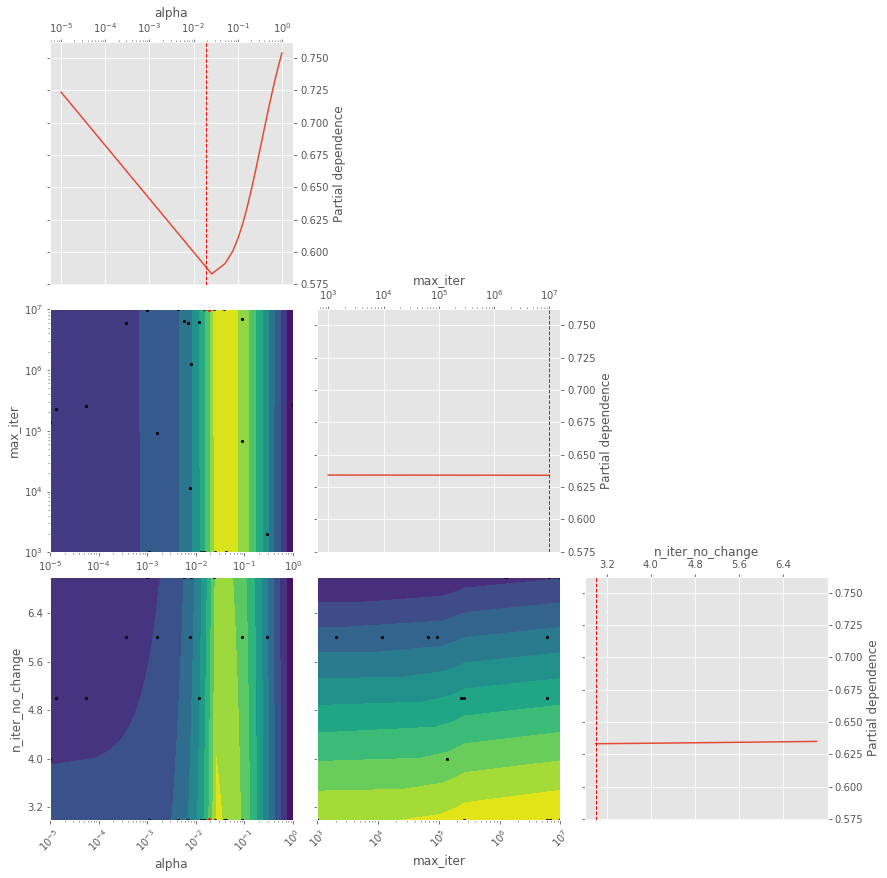

In [101]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['alpha','max_iter','n_iter_no_change'])


As already mentioned the results of the Bayesian hyperparameter optimization provides partial dependence plots very useful plot to determine which parameter is most impactful in reducing the error in the model. From the partial dependence plots, we can see that **for the given hyperparameter search space**, max_iter seems to have no impact. There is a minor impact from n_iter_no_change, but the majority of the change is coming from alpha with a clear minima around 1e-2 (based on partial dependence).

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **alpha = 0.018651**, **max_iter = 10e6**, and **n_iter_no_change = 3**.



### <i>Final Model</i><a class="anchor" id="M3A_Final"></a>

In [102]:
# Model with best hyperparameters
svm_sgd2 = SGDClassifier(alpha =clf_gp.x[0] # 0.018651097369382016 
                        ,class_weight = 'balanced'
                        ,fit_intercept=True
                        ,l1_ratio=0.0
                        ,learning_rate='optimal'
                        ,loss='hinge'
                        ,max_iter=clf_gp.x[1] # 10000000
                        ,n_iter_no_change=clf_gp.x[2] #3#
                        ,n_jobs = -1
                        ,penalty='l2'
                        ,verbose=0
                        ,random_state = 101
                        )

train_classifier(estimator=svm_sgd2, scl_obj=scl_obj, X=X2, y=y2, cv=cv_object, verbose=False)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 3.2976593971


confusion matrix
 [[ 854  243   49    9]
 [ 371 1136  285  100]
 [  47  410  267  377]
 [   7   70   63 1151]]
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1155
           1       0.61      0.60      0.61      1892
           2       0.40      0.24      0.30      1101
           3       0.70      0.89      0.79      1291

    accuracy                           0.63      5439
   macro avg       0.60      0.62      0.60      5439
weighted avg       0.60      0.63      0.61      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 3.0736145973


confusion matrix
 [[ 848  244   50   13]
 [ 411 1067  276  138]
 [  58  372  225  446]
 [   7   56   51 1177]]
              precision    recall  f1-score   support

           0       0.64      0.73      0.68      1155
           1       0.61      0.56      0.59      1892
           2       0.37      0.20      0.26      1101
           3       0.66      0.91      0.77      1291

    accuracy                           0.61      5439
   macro avg       0.57      0.60      0.58      5439
weighted avg       0.58      0.61      0.59      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 2.8735744953


confusion matrix
 [[ 847  240   58   10]
 [ 406 1079  295  112]
 [  52  402  237  410]
 [   8   72   55 1156]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1155
           1       0.60      0.57      0.59      1892
           2       0.37      0.22      0.27      1101
           3       0.68      0.90      0.78      1291

    accuracy                           0.61      5439
   macro avg       0.57      0.60      0.58      5439
weighted avg       0.58      0.61      0.59      5439



### Overall Measure

In [117]:
# Get the overall metrics for the model
piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd2)])  # and then do this

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_sv2 = -cv_results['test_custom_scorer'] # Since I want maximize the score
print("Custom Score across the folds")
print(score_tot_sv2)
print("Combined Score:",score_tot_sv2.mean() )

Custom Score across the folds
[0.54366612 0.58613716 0.57841515]
Combined Score: 0.5694061408347122


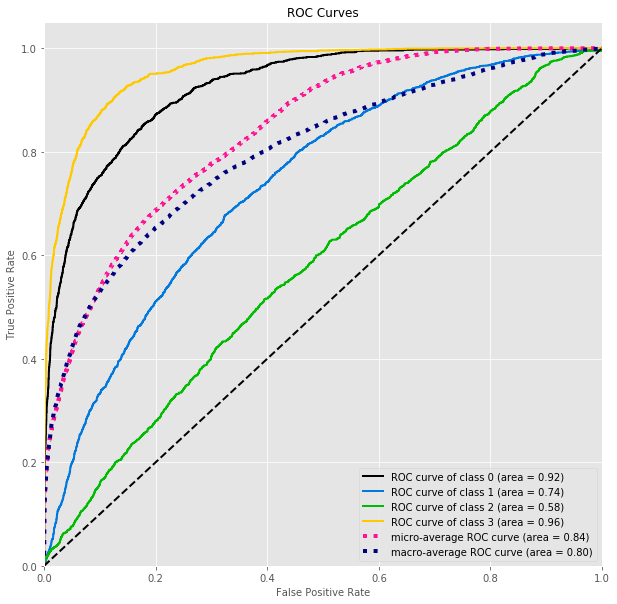

In [122]:
piped_object = Pipeline([('scale', std_scl),  # do this
                             ('svm_model', svm_sgd2)]) # and then do this
getROCMulti(piped_object,X2,y2,test_size=0.3,isSVG=True)


### Variable Importance for Months since promotion 0-12

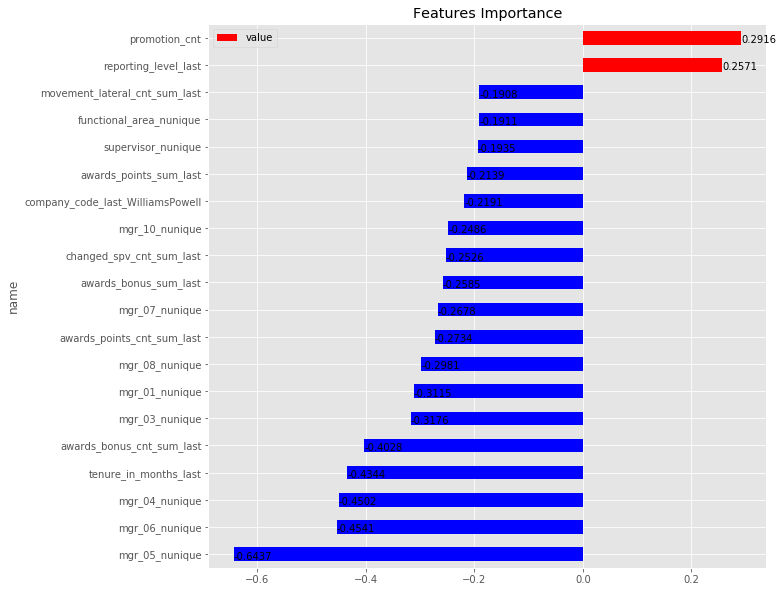

In [126]:

varImpSVM(svm_sgd2,20,df2ColNames,classId=0)

### Variable Importance for Months since promotion 12-24

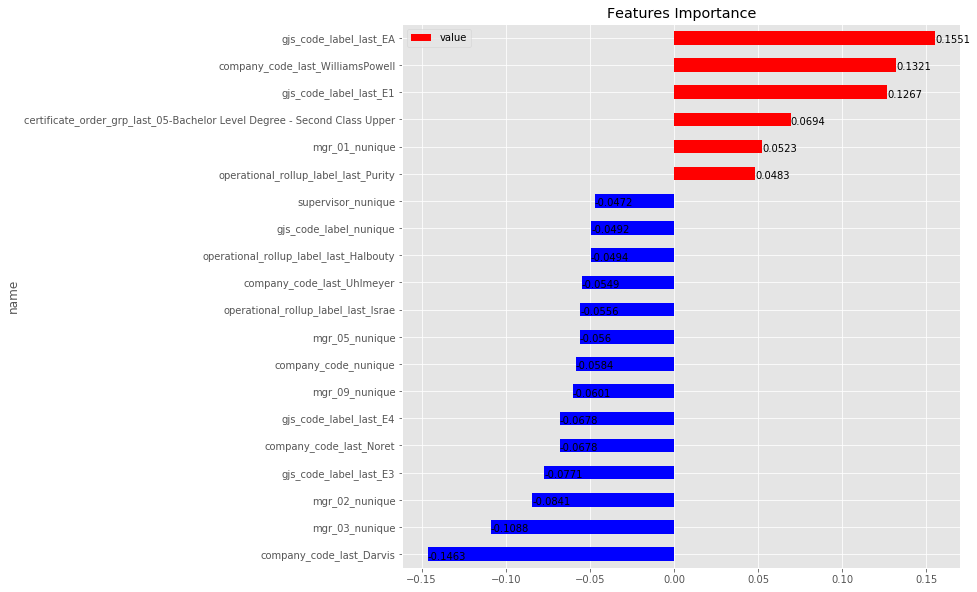

In [127]:
varImpSVM(svm_sgd2,20,df2ColNames,classId=1)

### Variable Importance for Months since promotion 24-36

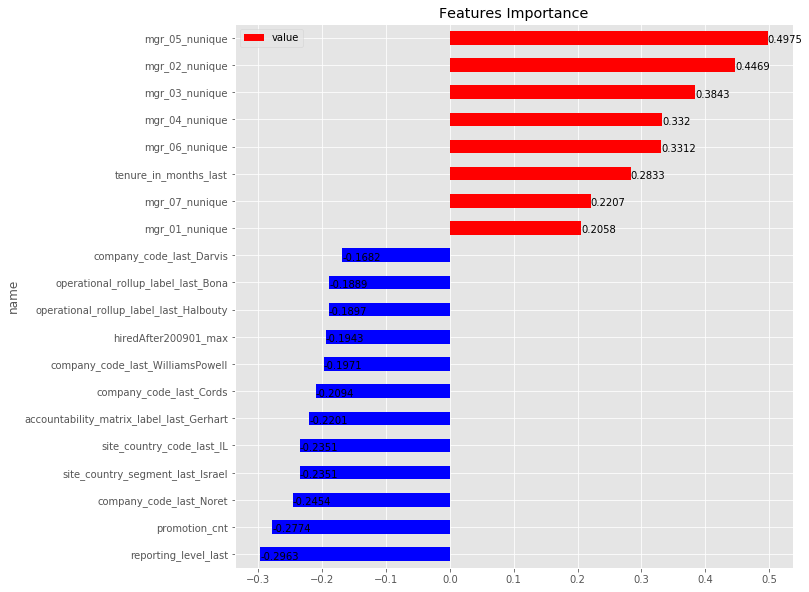

In [128]:
varImpSVM(svm_sgd2,20,df2ColNames,classId=3)

### Variable Importance for Months since promotion 36+

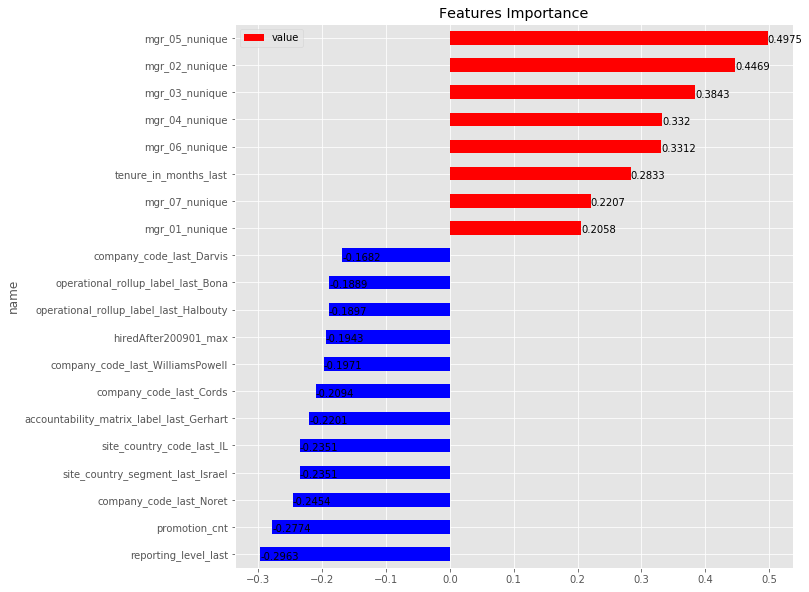

In [129]:
varImpSVM(svm_sgd2,20,df2ColNames,classId=3)


The final model that was created using these parameters produced a custom score of **0.569** across the 3-folds. This is **lower** than the baseline SVM model that we developed in the initial step (0.608). A lower score is better due to our predictions being more closely in line with the actual classes.

The ROC curve for the model shows that the prediction for the test dataset for all the classes has a mean AUC of 0.80 (macro-averaged ROC) across the 3-folds. This value is above what we would have achieved (AUC = 0.5) with random guessing.


### <font color=maroon><i>Model Two - Random Forest</i></font><a class="anchor" id="EM_M2"></a>

In [130]:
# baseline Random Forest Model

rf_time_std =RandomForestClassifier( n_estimators=1500
                                , max_depth=None
                                , min_samples_split=20
                                , min_samples_leaf=20
                                , n_jobs=-1
                                , class_weight='balanced'
                                , random_state = 101 ) 

In [131]:
train_classifier(estimator=rf_time_std, X=X2, y=y2, cv=cv_object,verbose=False)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 11.8371837139


confusion matrix
 [[ 996  127   28    4]
 [ 219 1314  307   52]
 [  37  106  731  227]
 [   4   10  183 1094]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1155
           1       0.84      0.69      0.76      1892
           2       0.59      0.66      0.62      1101
           3       0.79      0.85      0.82      1291

    accuracy                           0.76      5439
   macro avg       0.75      0.77      0.76      5439
weighted avg       0.77      0.76      0.76      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 11.7891788483


confusion matrix
 [[ 995  128   29    3]
 [ 219 1295  303   75]
 [  39  114  718  230]
 [   2    7  184 1098]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1155
           1       0.84      0.68      0.75      1892
           2       0.58      0.65      0.61      1101
           3       0.78      0.85      0.81      1291

    accuracy                           0.75      5439
   macro avg       0.75      0.76      0.75      5439
weighted avg       0.76      0.75      0.76      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 11.8471844196


confusion matrix
 [[ 996  121   32    6]
 [ 205 1278  352   57]
 [  32  114  737  218]
 [   5    9  187 1090]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1155
           1       0.84      0.68      0.75      1892
           2       0.56      0.67      0.61      1101
           3       0.80      0.84      0.82      1291

    accuracy                           0.75      5439
   macro avg       0.75      0.76      0.75      5439
weighted avg       0.77      0.75      0.76      5439



#### Combined Score for Baseline

In [132]:
# Get the overall metrics for the model
piped_object = Pipeline([('rf_model', rf_time_std)])  

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_rf2_baseline =-cv_results['test_custom_scorer']
print("Combined Custom Score across the folds")
print(score_tot_rf2_baseline.mean())

Combined Custom Score across the folds
0.33020775877918734



From our analysis above, we see that the baseline Random Forest model gives a combined total score for the baseline model is **0.330**.

The baseline Random Forest was created with most parameters set to default values (min_sample_split = 20, min_sample_leaf = 20, and n_estimators = 500). Similar to what was done in the SVM model, we weighed the classes according to the class frequencies.

### <i>Parameter Adjustments</i><a class="anchor" id="M3A_PA"></a>

Next, we wanted to see if we could improve this using grid search. We used Bayesian optimization to find the optimal hyperparameters to use. We will discuss this in detail under the "Exceptional Work" section and explain why we choose this approach over a general grid search approach.

For the Bayesian grid search, the search space was restricted to be within the following space:

- n_estimators: sampled from 100 to 1000
- max_depth: sampled from 10 to 1000
- min_samples_split: log-sampled from 1e-6 to 0.1
- min_samples_leaf: log-sampled from 1e-6 to 0.1

In [133]:
# set up hyperparameter space
space = [Integer(100, 1000, name='n_estimators')#, prior='log-uniform')
         ,Integer(10, 1000, name='max_depth')#, prior='log-uniform')
         ,Real(0.000001, 0.1, name='min_samples_split', prior='log-uniform')
         ,Real(0.000001, 0.1, name='min_samples_leaf', prior='log-uniform')
        ]

@use_named_args(space)
def objective(**params):
    rf_time_std =RandomForestClassifier(n_jobs=-1
                                        , random_state = 101 
                                        , class_weight='balanced'
                                        ,**params)
    
    piped_object = Pipeline([('rf_model', rf_time_std)])  

    # Define scorers (metrics) to use
    scoring = {'recall_promoted_only': make_scorer(recall_score, average='weighted') # Positive Class Only
               ,'f1_weighted': make_scorer(f1_score, average='weighted') # Weighted Score
                }
    custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator,greater_is_better=False)}
    # Get all metrics and define custom loss function using this data
    cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)
    loss = -np.mean(cv_results['test_custom_scorer'])
   
    return (loss)

In [134]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 poljints total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     ,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 20.9401
Function value obtained: 0.4965
Current minimum: 0.4965
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.6578
Function value obtained: 0.2526
Current minimum: 0.2526
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 29.7150
Function value obtained: 0.4965
Current minimum: 0.2526
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.7888
Function value obtained: 0.3316
Current minimum: 0.2526
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 25.2115
Function value obtained: 0.7178
Current minimum: 0.2526
Iteration No: 6 started. Evalua

In [135]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: 0.2344180915609487
Best params:
[707, 444, 1e-06, 1e-06]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001A5ABF98>,
      dtype=object)

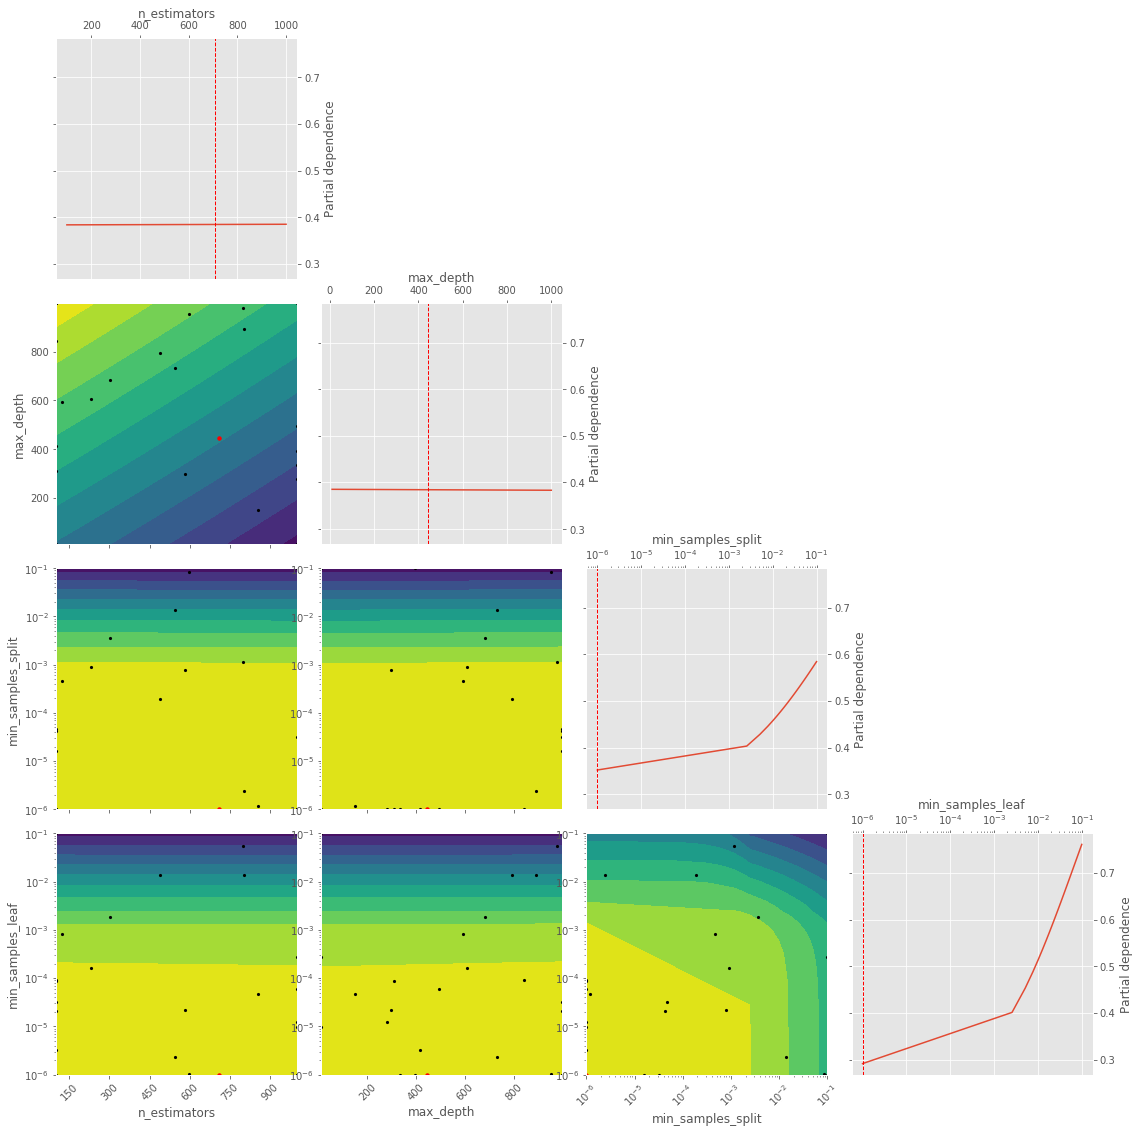

In [136]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['n_estimators','max_depth','min_samples_split','min_samples_leaf'])


From the partial dependence plots, we can see that for the given hyperparameter search space, n_estimator seems to have no impact on the model's metric. There is also no impact of max_depth, but the majority of the change is coming from min_samples_leaf wich has a  minimum value around 1e-6 (based on partial dependence).  Min_samples_split has also strong impact to the model with a minumum value at 1e-6. We could have run the grid with a lower value for these parameters, but 1e-6 already represent a leaf and minima with less than 4 elements, so further reduction would likely lead to overfitting.

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **n_estimators = 707**, **max_depth = 444**, **min_samples_split = 1e-6**, and **min_samples_leaf = 1e-6**.

### <i>Final Model</i><a class="anchor" id="M3A_Final"></a>

In [137]:
rf_time_std  =RandomForestClassifier(n_jobs=-1
                                     , random_state = 101 
                                     , n_estimators =  707 #clf_gp.x[0] 
                                     , max_depth = 444#  clf_gp.x[1] 
                                     , min_samples_split = 1e-06 #clf_gp.x[2] 
                                     , min_samples_leaf = 1e-6  #clf_gp.x[3] 
                                     , class_weight='balanced'
                                    )

In [138]:
train_classifier(estimator=rf_time_std, X=X2, y=y2, cv=cv_object,verbose=False)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 9.8099808693


confusion matrix
 [[ 975  176    3    1]
 [  90 1661  109   32]
 [  13  223  665  200]
 [   0   39   92 1160]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1155
           1       0.79      0.88      0.83      1892
           2       0.77      0.60      0.68      1101
           3       0.83      0.90      0.86      1291

    accuracy                           0.82      5439
   macro avg       0.82      0.81      0.81      5439
weighted avg       0.82      0.82      0.82      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 9.474947691


confusion matrix
 [[ 948  200    5    2]
 [  76 1661  109   46]
 [   9  234  659  199]
 [   0   31   89 1171]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1155
           1       0.78      0.88      0.83      1892
           2       0.76      0.60      0.67      1101
           3       0.83      0.91      0.86      1291

    accuracy                           0.82      5439
   macro avg       0.82      0.80      0.81      5439
weighted avg       0.82      0.82      0.81      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 9.856985569


confusion matrix
 [[ 962  185    5    3]
 [  69 1664  118   41]
 [  10  223  677  191]
 [   1   37   95 1158]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1155
           1       0.79      0.88      0.83      1892
           2       0.76      0.61      0.68      1101
           3       0.83      0.90      0.86      1291

    accuracy                           0.82      5439
   macro avg       0.82      0.81      0.81      5439
weighted avg       0.82      0.82      0.82      5439



### Overall Measure

In [139]:
# Get the overall metrics for the model
piped_object = Pipeline([('rf_model', rf_time_std)])  

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_rf2 =-cv_results['test_custom_scorer']
print("Custom Score across the folds")
print(score_tot_rf2)

Custom Score across the folds
[0.22927009 0.23699209 0.23699209]


In [140]:
print("Combined Custom Score across the folds",score_tot_rf2.mean())

Combined Custom Score across the folds 0.2344180915609487


## ROC

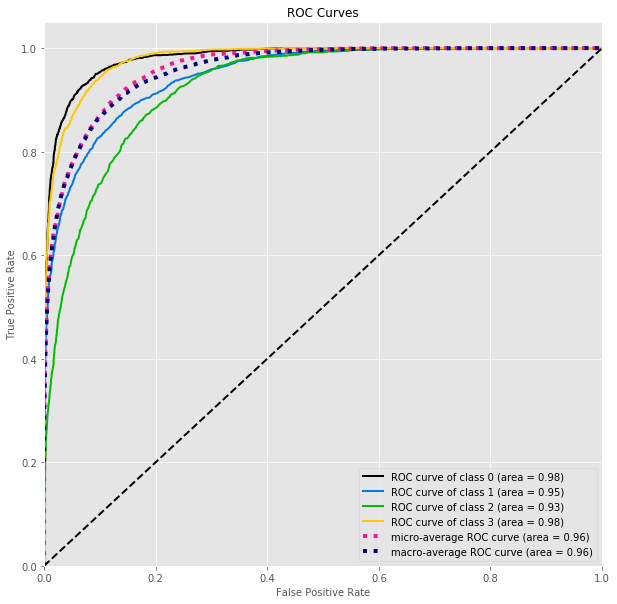

In [141]:
getROCMulti(rf_time_std,X2,y2,test_size=0.3) 

## Variable Importance

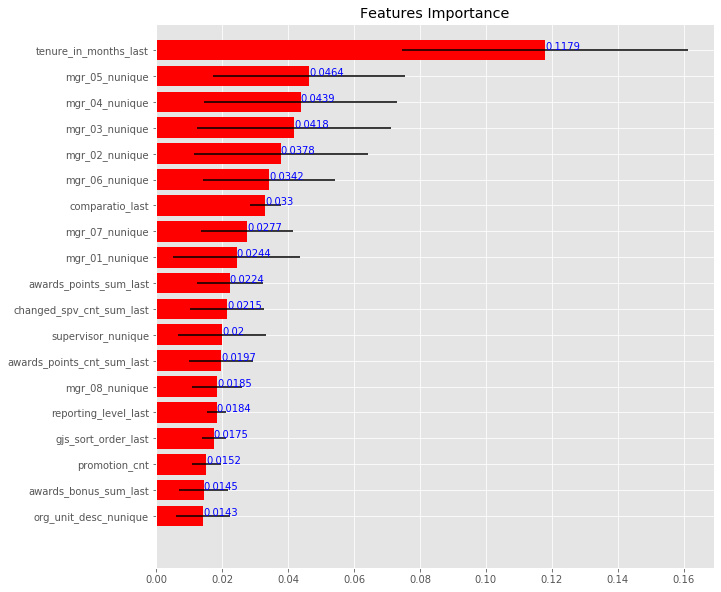

In [142]:
varImpRFStDev(rf_time_std,20,df2ColNames)
#skplt.estimators.plot_feature_importances(rf_time_std,feature_names=df2ColNames,x_tick_rotation=90,figsize=[10,5])



The final model that we produced using these parameters produces a custom score of **0.234**. This is **better** than the baseline  model that we developed in the initial step (0.330).

The ROC curve for the model shows that the prediction for the test dataset for all the classes is well above the random threshold of 0.5. Class 0 (0-12 months) has an AUC of 0.98. Class 1 (12-24 months) has an AUC of 0.95. Class 2 (24-36 months) has an AUC of 0.93. Finally, class 3 (more than 36 months) has an AUC of 0.98. This is in line with the expectation as the company has a pre-defined process to promote new college graduates within the first 12 months, and is more complex to predict promotions between 1 and 3 years. We can conclude that this Random Forest model performed better than the SVM model.

### <font color=maroon><i>Model Three - k-Nearest Neighbors (KNN) </i></font><a class="anchor" id="EM_M3"></a>

In [143]:
# Baseline KNN model

knn_time_std = KNeighborsClassifier(n_neighbors=3
                               ,weights='uniform'
                               ,algorithm ='auto'
                               ,p=2 #euclidian distance
                               ,n_jobs=-1
                              ) 

In [144]:
train_classifier(estimator=knn_time_std, scl_obj=scl_obj, X=X2, y=y2, cv=cv_object)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 19.5519549847


confusion matrix
 [[ 788  293   44   30]
 [ 390 1242  189   71]
 [ 142  369  398  192]
 [ 103  248  198  742]]
              precision    recall  f1-score   support

           0       0.55      0.68      0.61      1155
           1       0.58      0.66      0.61      1892
           2       0.48      0.36      0.41      1101
           3       0.72      0.57      0.64      1291

    accuracy                           0.58      5439
   macro avg       0.58      0.57      0.57      5439
weighted avg       0.59      0.58      0.58      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 17.0447041988


confusion matrix
 [[ 765  326   37   27]
 [ 382 1228  200   82]
 [ 141  407  361  192]
 [ 111  224  214  742]]
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1155
           1       0.56      0.65      0.60      1892
           2       0.44      0.33      0.38      1101
           3       0.71      0.57      0.64      1291

    accuracy                           0.57      5439
   macro avg       0.57      0.55      0.55      5439
weighted avg       0.57      0.57      0.56      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 19.2709271908


confusion matrix
 [[ 775  297   55   28]
 [ 414 1185  211   82]
 [ 160  391  385  165]
 [ 125  255  198  713]]
              precision    recall  f1-score   support

           0       0.53      0.67      0.59      1155
           1       0.56      0.63      0.59      1892
           2       0.45      0.35      0.39      1101
           3       0.72      0.55      0.63      1291

    accuracy                           0.56      5439
   macro avg       0.56      0.55      0.55      5439
weighted avg       0.57      0.56      0.56      5439



#### Combined Score for Baseline model

In [145]:
# Get the overall metrics for the model
piped_object = Pipeline([('scale', std_scl),  # do this
                          ('knn_model', knn_time_std)]) 

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_knn2_baseline = -cv_results['test_custom_scorer']
print("Combined Custom Score across the folds")
print(score_tot_knn2_baseline.mean())

Combined Custom Score across the folds
0.9197769197769198



From our analysis above, we see that the baseline k-Nearest Neighbors model gives a custom score of **0.920**. This is worse than  any other models we have produced so far for this task.

The baseline KNN was created with most parameters set to default values. We used the default 'auto' selection algorithm to let the model decide the best option. Each of the neighbors was weighted equally for the baseline model without accounting for the distance from the test observation under consideration (default value in model). On subsequent analyses, we found that weighing the neighbors based on distance from test observations instead of uniformly produced better results (most likely because the feature space was sparse), and for this reason we used this for future parameter optimization. We also found that the KDtree algorithm gave better results than Ball Tree, so KDtree was used for further parameter optimization in the next section.

### <i>Parameter Adjustments</i><a class="anchor" id="M3A_PA"></a>

Next, we wanted to see if we could improve this using grid search. We used Bayesian optimization to find the optimal hyperparameters to use. For the Bayesian grid search, the search space was restricted to be within the following space:

- n_neighbors: sampled from 1 to 100
- p: sampled from either 1 or 2 (Manhattan distance or Euclidean distance, respectively)
- leaf_size: sampled from 1 to 60

In [146]:
# set up hyperparameter space
space = [Integer(1, 100, name='n_neighbors')#, prior='log-uniform')
         ,Integer(1, 2, name='p')#, prior='log-uniform')
#          ,Categorical(['uniform','distance'],name='weights')
#          ,Categorical(['ball_tree','kd_tree'],name='algorithm')
         ,Integer(1,60,name='leaf_size')
        ]

# Object to scale the inputs before training
std_scl = StandardScaler(with_mean=True,with_std=True)

@use_named_args(space)
def objective(**params):
    knn_std = KNeighborsClassifier(n_jobs=-1
                                   ,weights='distance'
                                   ,algorithm='kd_tree'
                                   ,**params)
    
    piped_object = Pipeline([('scale', std_scl),  
                             ('knn_model', knn_std)])  

    # Define scorers (metrics) to use
    custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator,greater_is_better=False)}
    
    cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)
    loss = -np.mean(cv_results['test_custom_scorer'])
   
    return (loss)

In [147]:
clf_gp = gp_minimize(objective
                     ,space
                     ,n_random_starts=10 # 10 random points to start 
                     ,n_calls=25 # pick 25 poljints total (including n_random_starts) to dinf optimal combination of hyperparameters
                     ,verbose=True
                     ,n_jobs=-1
                     ,random_state=101
                    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 56.6657
Function value obtained: 0.7874
Current minimum: 0.7874
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 54.8065
Function value obtained: 0.7825
Current minimum: 0.7825
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 56.5497
Function value obtained: 0.5954
Current minimum: 0.5954
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 56.2926
Function value obtained: 0.6314
Current minimum: 0.5954
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 51.8292
Function value obtained: 0.7699
Current minimum: 0.5954
Iteration No: 6 started. Evalu

c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 220.1570
Function value obtained: 0.5731
Current minimum: 0.5731
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 57.4497
Function value obtained: 0.8129
Current minimum: 0.5731
Iteration No: 21 started. Searching for the next optimal point.


c:\users\mmoro\scikit-optimize\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 224.2064
Function value obtained: 0.5731
Current minimum: 0.5731
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 161.4871
Function value obtained: 0.5749
Current minimum: 0.5731
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 56.8697
Function value obtained: 0.5778
Current minimum: 0.5731
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 218.2068
Function value obtained: 0.5747
Current minimum: 0.5731
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 205.2545
Function value obtained: 0.5766
Current minimum: 0.5731


In [148]:
print('Best score: {}'.format(clf_gp.fun))
print('Best params:')
print(clf_gp.x)

Best score: 0.5731445731445731
Best params:
[31, 1, 1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000048EC7748>,
      dtype=object)

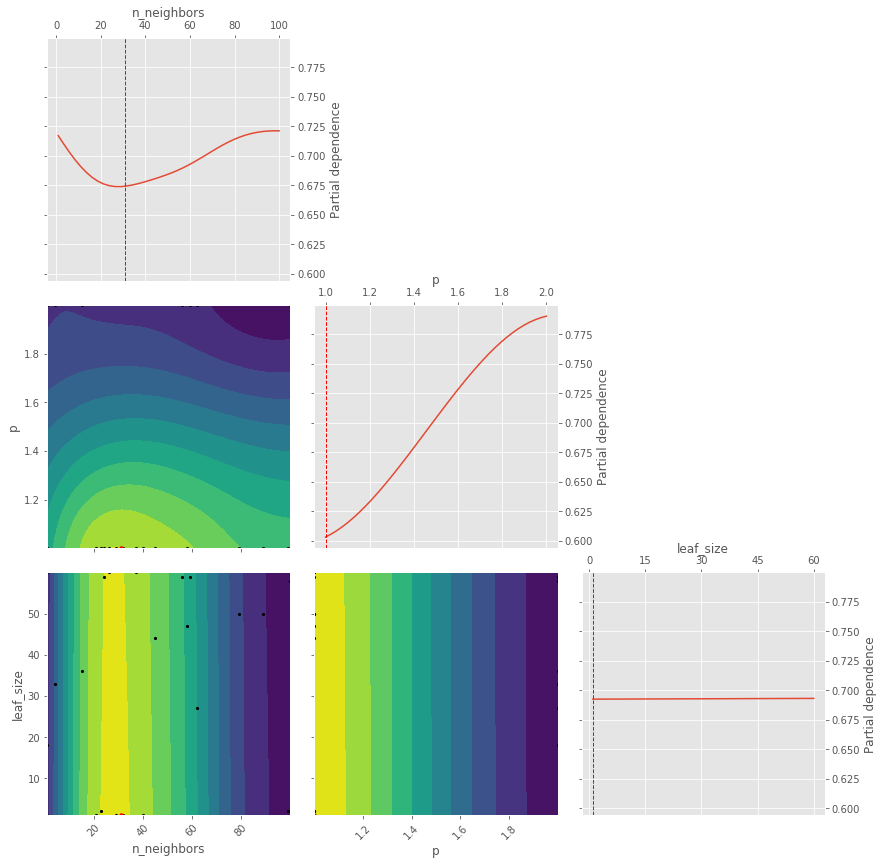

In [149]:
skopt.plots.plot_objective(clf_gp, size=4, dimensions=['n_neighbors','p','leaf_size'])


From the partial dependence plots, we can see that for the given hyperparameter search space, leaf_size seems to have no impact. There is a minor impact from n_neighbors, but the majority of the change is coming from p, where the error is much lower for Manhattan distance (p=1) than for Euclidean Distance (p=2). 

The most optimal parameters when all are allowed to change simultaneously is also provided by the Bayesian hyperparameter optimizer, and this is achieved at **n_neighbors = 31**, **p = 1** and **leaf_size = 1**.

### <i>Final Model</i><a class="anchor" id="M3A_Final"></a>

In [150]:
std_scl = StandardScaler(with_mean=True,with_std=True)            

knn_time_std = KNeighborsClassifier(n_neighbors=clf_gp.x[0]  #31 #
                              ,p= clf_gp.x[1]  #1
                              ,leaf_size= clf_gp.x[2] #1
                              ,weights='distance'
                              ,algorithm ='kd_tree'
                              ,n_jobs=-1
                              )    

In [151]:
train_classifier(estimator=knn_time_std, scl_obj=std_scl, X=X2, y=y2, cv=cv_object)

INFO:root: SVM: Iteration 1: Time Taken (seconds): 63.0693063736


confusion matrix
 [[ 724  390   23   18]
 [ 197 1523  124   48]
 [  45  477  410  169]
 [  13  212  183  883]]
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1155
           1       0.59      0.80      0.68      1892
           2       0.55      0.37      0.45      1101
           3       0.79      0.68      0.73      1291

    accuracy                           0.65      5439
   macro avg       0.67      0.62      0.63      5439
weighted avg       0.66      0.65      0.64      5439



INFO:root: SVM: Iteration 2: Time Taken (seconds): 68.1798171997


confusion matrix
 [[ 703  414   23   15]
 [ 191 1514  132   55]
 [  46  468  418  169]
 [  20  178  194  899]]
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1155
           1       0.59      0.80      0.68      1892
           2       0.54      0.38      0.45      1101
           3       0.79      0.70      0.74      1291

    accuracy                           0.65      5439
   macro avg       0.66      0.62      0.63      5439
weighted avg       0.66      0.65      0.64      5439



INFO:root: SVM: Iteration 3: Time Taken (seconds): 62.352234602


confusion matrix
 [[ 740  377   27   11]
 [ 213 1488  138   53]
 [  42  474  403  182]
 [  14  208  201  868]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1155
           1       0.58      0.79      0.67      1892
           2       0.52      0.37      0.43      1101
           3       0.78      0.67      0.72      1291

    accuracy                           0.64      5439
   macro avg       0.66      0.62      0.63      5439
weighted avg       0.65      0.64      0.64      5439



### Overall Measure

In [152]:
# Get the overall metrics for the model
piped_object = Pipeline([('scale', std_scl),  # do this
                          ('knn_model', knn_time_std)]) 

custom_scorer = {'custom_scorer':make_scorer(custom_scorer_calculator, greater_is_better=False)}

cv_results = cross_validate(piped_object, X2, y2, cv=cv_object, scoring = custom_scorer)

score_tot_knn2 = -cv_results['test_custom_scorer']
print("Custom Score across the folds")
print(score_tot_knn2)

Custom Score across the folds
[0.57565729 0.568303   0.57547343]


In [153]:
print("Combined custom Score across the folds",score_tot_knn2.mean())

Combined custom Score across the folds 0.5731445731445731


## ROC

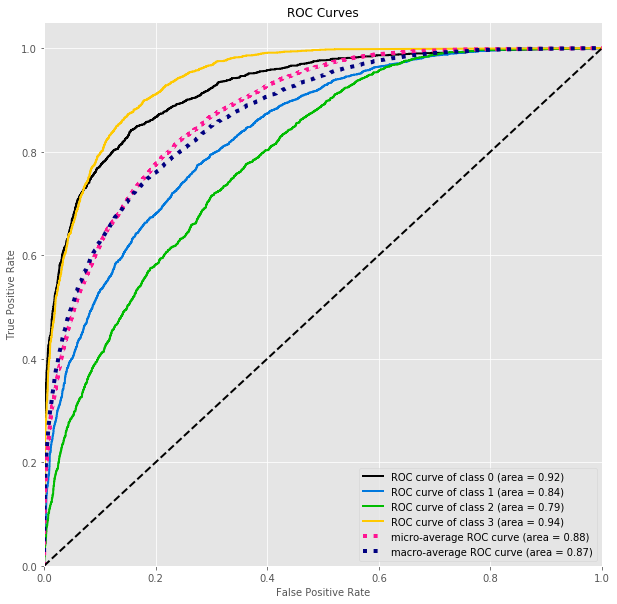

In [154]:
piped_object = Pipeline([('scale', std_scl),  # do this
                          ('knn_model', knn_time_std)]) # and then do this
getROCMulti(piped_object,X2,y2) 

..........

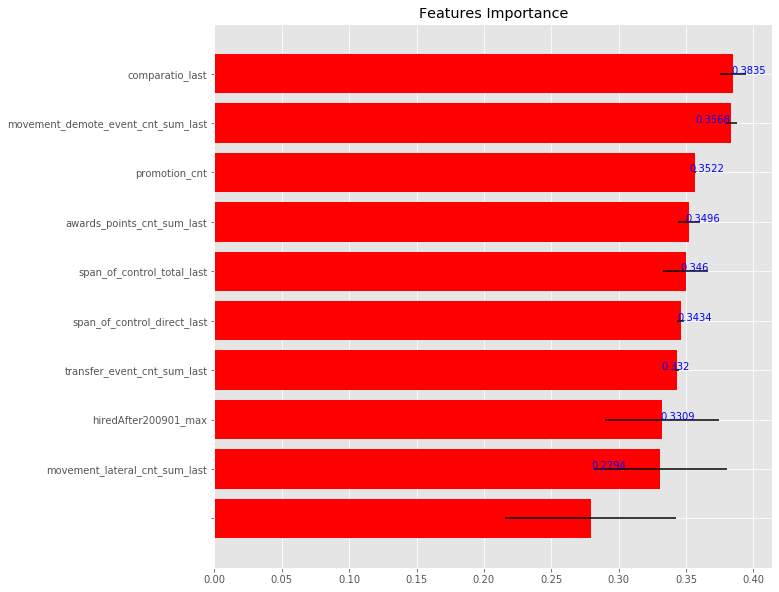

In [155]:
#show first 20 without order
#VarImpKNN(knn_std,X,y,colNames,cv_object,20) #too slow
VarImpKNN(knn_time_std,X2,y2,df2ColNames,cv_object,10,10)


The final model of KNN has a combined score of **0.573**, which is better than the baseline KNN model but still **worse** than both the SVM and Random Forest models.

Similar to the KNN for the Task 1, since the KNN model did not give very good results compared to SVM and Random Forest, we are just showing this process for 10 features as an exercise, but we will rely on the feature importance from Random Forest instead to draw any insights.

The ROC curve for the model shows that the prediction for the test dataset for all the classes has a mean AUC of 0.87 across the 3-folds (mean of macro-AUC). This value is above the random threshold of 0.5. 

[Back to Table of Contents](#TOC)

# <font color=maroon>Model Analysis</font><a class="anchor" id="EM_MA"></a>

Similar to Task 1, we are running multiple models and each model has multiple folds, it can be difficult to compare and chose the best one based on a defined metric. We will again use a boxplot visualization to compare the performance of models and provide key pieces of information.

Text(0.5, 1.0, '')

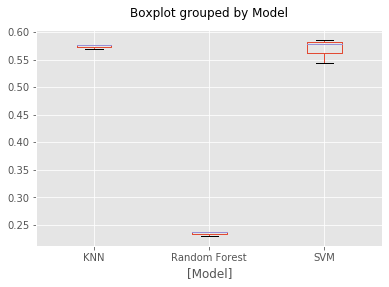

In [156]:
task2_scores = pd.DataFrame(data={'Model':'SVM','Score':score_tot_sv2}).append(
                        [pd.DataFrame(data={'Model':'Random Forest','Score':score_tot_rf2})
                         ,pd.DataFrame(data={'Model':'KNN','Score':score_tot_knn2})
                        ])

#plt.boxplot()
task2_scores.boxplot(by='Model')
plt.title('')

| Model        | SVM      | Random Forest   |    KNN       |
|:------------:|:--------:|:---------------:|:------------:|
|Custom Score Mean  |   0.569  |<b>   0.234  </b>|     0.573    |
|Custom Score Standard Deviation  |   0.0226  |<b>   0.0045  </b>|     0.0042    |


The boxplot visualization above shows that the **Random Forest** model has the best custom score. We see visual overlap between SVM and KNN but significant separation between these model scores and the Random Forest model score. It is important to note that if we were to choose between SVM and KNN, we would pick the KNN model because it has a smaller standard deviation indicating less overfitting compared to SVM.

Next we will do a statistical comparison of the scores to quantify the difference in the performance of the models.

[Back to Table of Contents](#TOC)

# <font color=maroon>Model Comparison</font><a class="anchor" id="EM_MC"></a>

#### Statistical Difference between Models

For this task, a lower measure corresponds to a better model. While comparing two models if the difference in scores yields a negative value, then the first model is better.

In [158]:
print("Statistical Difference between Random Forest and SVM:")
compare_models(score_tot_rf2,score_tot_sv2)

print("\nStatistical Difference between Random Forest and KNN:")
compare_models(score_tot_rf2,score_tot_knn2)

print("\nStatistical Difference between SVM and KNN:")
compare_models(score_tot_sv2,score_tot_knn2)

Statistical Difference between Random Forest and SVM:
Range of difference = -0.372 to -0.29798

Statistical Difference between Random Forest and KNN:
Range of difference = -0.35402 to -0.32343

Statistical Difference between SVM and KNN:
Range of difference = -0.05561 to 0.04814


The statistical comparison section above uses a t-test to compare the scores of all models. At a 95% confidence interval, we can reject the null hypothesis that the Random Forest model has the same custom score as the KNN and SVM models. Meanwhile, we cannot reject the null hypothesis that SVM and KNN have same custom score.

### <i>Advantages of Models</i><a class="anchor" id="EM_Results"></a>

Since we have a lot of features in the dataset that can predict the promotion window, the classes may not be separated well. Also, various factors in combination would likely be needed to accurately predict the promotion window. 

The challenge with using KNN is similar to task 1: the feature space is expremely sparse, and therefore the nearest neighbors may still be relatively far away and may not be a good predictor for the test observation classes.

For SVM, we were limited to using the Linear SVM model since we were using Stocastic Gradient Descent. Since the feature space might be highly non-linear, this may not be able to capture all the nuances in the features accurately while classifying the observations. Consequently, the performance of the SVM model though good, was not much better than the KNN model.

Random Forest produced the best results since it is not impacted by neither the sparsity of the feature space nor by the non-linear feature space. By taking decisions on various features at differnt nodes in the tree, the Random Forest model was able to capture the non-linear behavior better than the SVM and KNN models, and we see that from the custom score calculated for all 3 models.

The summary of the results from the models reported above show that **Random Forest** model has the best performance for task 2.



[Back to Table of Contents](#TOC)

# <font color=maroon>Important Attributes</font><a class="anchor" id="EM_IA"></a>

Since Random Forest was the best performing model  we will use this model to analyze the feature importance.

Under the Random Forest classification, we see that the attribute tenure_in_months_last has a strong influence on the model, followed by the managerial structure attributes. Even if we cannot derive directionality from the variable importance, we can see that this situation is inline with the business understanding. Less tenured employees may have a faster promotion rate, while employees with higher tenure, like senior professionals, may have be at job levels that have a slower promotion rate. 



###  <font color=blue>Theme 1 - Performance </font> <a class="anchor" id="LRM_T1"></a>


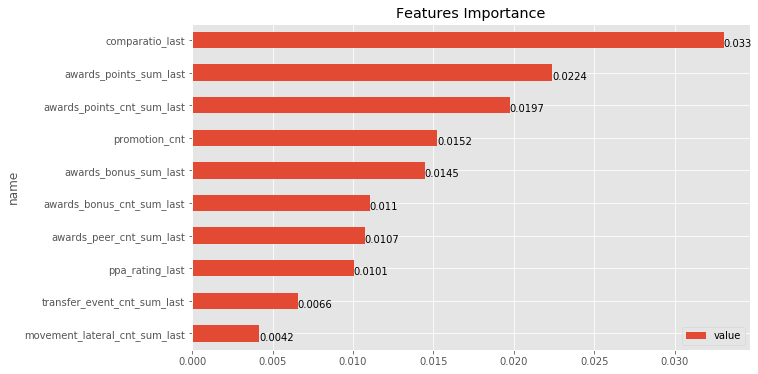

In [159]:
varImpRF(rf_time_std,20,df2ColNames,rating_related,figsize=[10,6])


**Observations:**

- The two highest features under the performance theme comparatio_last and awards_points_sum_last.
- Realistically, these make sense – an employee’s award point count likely has a large influence on their promotability, while a higher compensation level may lead to a opportunity to advance to the next promotion level.

###  <font color=blue>Theme 2 - Supervision Status </font> <a class="anchor" id="LRM_T2"></a>


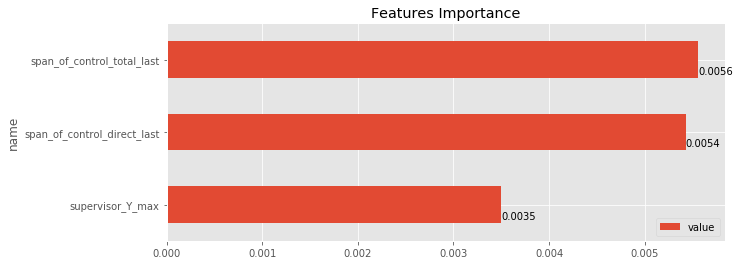

In [160]:
varImpRF(rf_time_std,20,df2ColNames,supervision_related,figsize=[10,4])


**Observations:**
- All the weights for this theme are very small (< 0.006) and do not seem to have an impact on the prediction of a promotion window

###  <font color=blue>Theme 3 - Regional </font><a class="anchor" id="LRM_T3"></a>


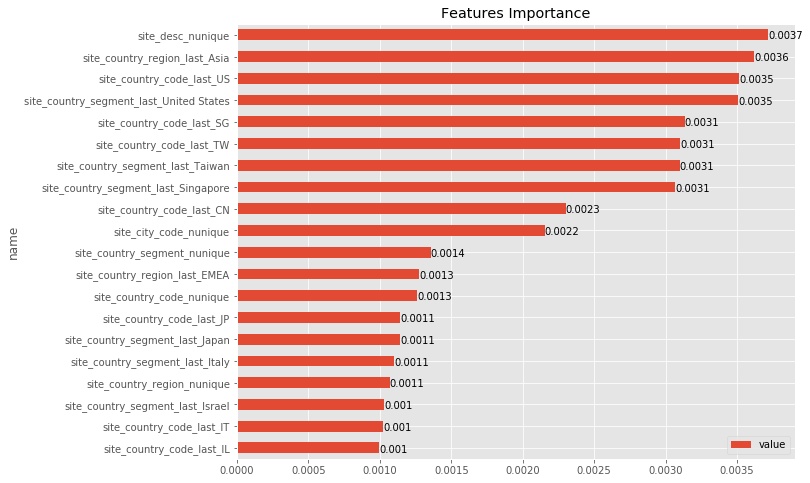

In [161]:
varImpRF(rf_time_std,20,df2ColNames,region_related,figsize=[10,8])


**Observations:**
- While many countries and sites may have some impact on the promotion window, it appears as though Asia and the United States have the most impact (though all weights are < 0.004). 


###  <font color=blue>Theme 4 - Manager</font> <a class="anchor" id="LRM_T4"></a>

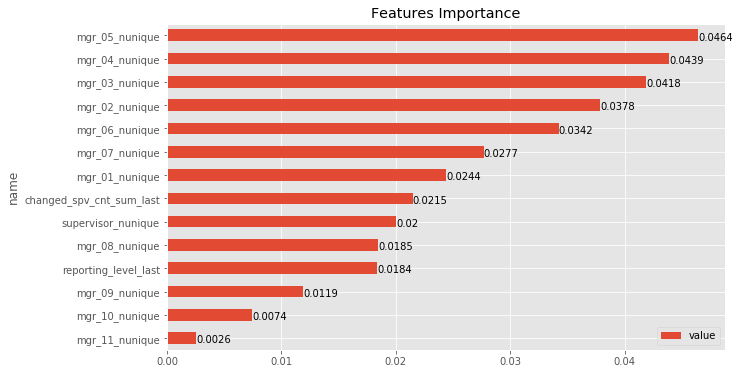

In [162]:
varImpRF(rf_time_std,20,df2ColNames,manager_related,figsize=[10,6])


**Observations:**

- It is noticeable that the number of mid to upper level managers strongly impact the promotion likelihood. We know from the exploratory data analysis that these variables were highly correlated, and because of multicollinearity the weights for these variables can be influenced by each other. Hence, we cannot conclude any causation based on these weights alone.
- The number of supervisors also has a moderate influence on promotability (changed_spv_cnt_sum_last).

### <font color=blue>Theme 5 - Functional Area </font> <a class="anchor" id="LRM_T5"></a>


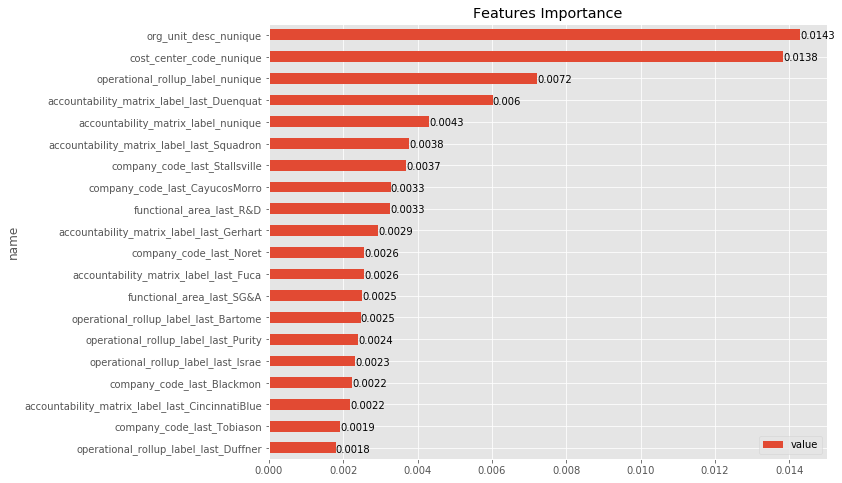

In [163]:
varImpRF(rf_time_std,20,df2ColNames,func_area_related,figsize=[10,8])


**Observations:**
- The features outstanding in this theme are org_unit_desc_nunique and cost_center_code_nunique. It looks like the number of organization units and cost centers an employee has worked in greatly impacts the time to promotion. Although we cannot derive directionality from this measure, it is likely that the experience accumulated from different groups is a factor on the speed of promotion.

###  <font color=blue> Theme 6 - Job Grade </font> <a class="anchor" id="LRM_T6"></a>


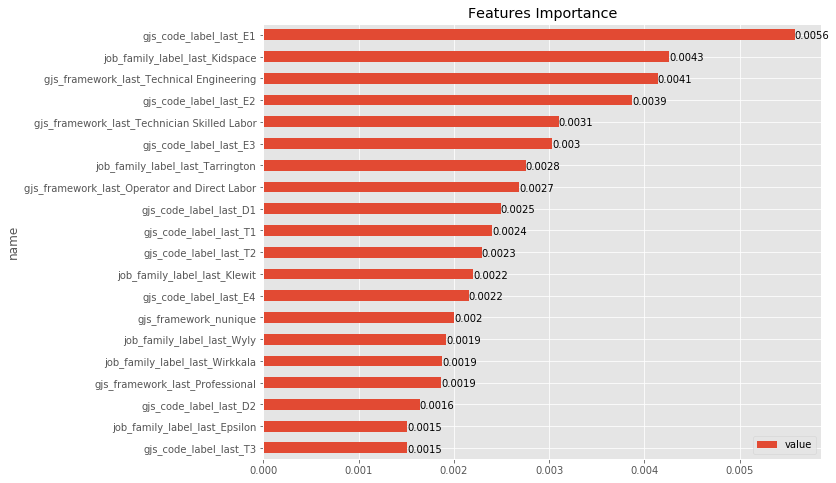

In [164]:
varImpRF(rf_time_std,20,df2ColNames,job_grade_related,figsize=[10,8])


**Observations:**

- One variable in the gjs_code_label_last fature stands out: E1. This is in line with the company policy where new entry worker (E1) is expected to be promoted to the next level (E2) within a defined time frame (12 months).
- Other values in the gjs_code_label_last have differing impact on promotability, perhaps indicative of dead-end roles or peak career levels (like E4 and T3).


###  <font color=blue>Theme 7 - Tenure </font> <a class="anchor" id="LRM_T7"></a>


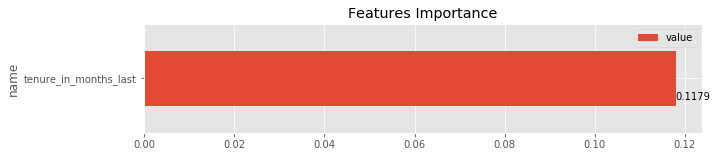

In [165]:
varImpRF(rf_time_std,20,df2ColNames,tenure_related,figsize=[10,2])


**Observations:**
- Tenure also has a large impact on promotability in terms of promotion windows. Logically, this makes sense as this is correlated with business practice in the company mentioned above.

###  <font color=blue>Theme 8 - Education </font> <a class="anchor" id="LRM_T8"></a>


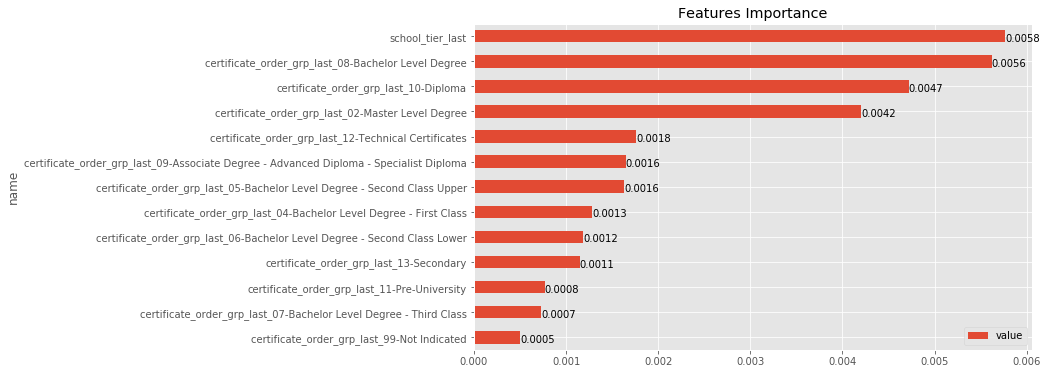

In [166]:
varImpRF(rf_time_std,20,df2ColNames,education_related,figsize=[10,6])


**Observations:**
- Several education features have an impact on the promotion window prediction. These features lean towards higher education achievements and from preferred schools, so this is inline with our expectations. 

[Back to Table of Contents](#TOC)


# <font color = maroon>Deployment</font> <a class="anchor" id="Section8"></a>

With this analysis we built a dual-model system where a first model is able to predict promotability, and the second model is able to predict the promotion windows for the employees are likely to get promoted.

Organizations are constantly faced with the issue of retention/attrition, and poor retention can substantially hinder growth and be very costly. This dual-model system will be able to alert managers regarding employees that are ready for promotion, and prepare them to initiate the conversation and processes need to develop their workforce into to their next role. As mentioned in the previous work, 45% of employees leave their job due to lack of opportunities for advancement [1], so a proactive approach in promotion conversation would benefit employee retention and consequently save money for the overall business.

To validate the impact, the models will be rolled out for pilot testing. In our initial analysis, financial valuations for determining the ROI of the model were based on a reduction of attrition, so comparing the change in the attrition levels between the pilot group and the rest of the company will be used to measure the business impact of the model. 

If the model is successful in reducing the attrition on the pilot group, it will be rolled out on a larger scale by deploying in the company's talent management system. When an employee record is flagged as having potential for promotion, a notification including the estimated promotion window will be automatically sent to the manager through the talent management system. Additionally, there will be a simple binary feedback mechanism so that the managers can provide feedback on whether they agree with the prediction of the model or not. 

This information will be aggregated and used to further tune the model. The model will be updated bi-annually and monitored using a dashboard that will compare year over year changes in actual promotion/attrition by segments, and compare these with the model recommendations. 


[Back to Table of Contents](#TOC)


# <font color = maroon>Exceptional Work</font> <a class="anchor" id="Section9"></a>

### <i>Grid Search</i><a class="anchor" id="EW_1"></a>

In the minilab, we performed a grid search to optimize one parameter at a time (independent of all other hyperparameters). From that exercise, we recognized the inefficiencies in this approach due to potential hyperparameter interactions, so we sought to optimize multiple hyperparameters simultaneously to account for interactions. 

The drawback to this approach is that the time taken to find the most optimum hyperparameters can be extremely high. For example, if we have 3 hyperparameters and each can take 5 discrete values (or we discretize the range for continuous hyperparameters to 5 arbitrary levels for the hyperparameter grid), we would have to create 125 models (permutation of all 3 hyperparameter values: 5 * 5 * 5 = 125) to find the optimum set of hyperparameters. Even then, these might miss the true optimal hyperparameter values since we have discretized the continuous hyperparameter values.

A better approach to avoid the above problem is to do random grid search. Yet again, this has a problem that we may still not find the optimum set of hyperparameters due to random sampling.

One step further is a Bayesian optimization based hyperparameter search. This is similar to a random grid search with one major exception: at every step of the grid search, the Bayesian optimizer tries to predict where it should sample the next set of hyperparameters that are most likely to provide better evaluation metrics on the model. To accomplish this, the optimizer is fed some initial random points on the grid (say 5 or 10). Based on these points, it creates a probability of improvement (of measured metrics) curve across the hyperparameter space. It picks the next point from this space that it thinks will give the maximum probability of improvement. Now, this point may or may not give an improvement in the metric initially, but more collected points greatly improve the probability of improvement curve. With only a handful of iterations, the optimizer is able to converge to an optimal solution. In our examples, we could converge to an optimal solution in as few as 25 iteration as opposed to the 125+ models (iterations) it would have taken with random grid search. 

The package that we used (scikit-optimize) also provided a very useful partial dependence plot which detailed information about the most critical hyperparameters for the pre-defined metrics. This allowed us to focus our time on tuning more important hyperparameters.

### <i>Custom Metrics</i><br> <a class="anchor" id="EW_2"></a>
While most algorithms will provide standard metrics (such as recall, precision, F1 score, accuracy and confusion matrices), it can sometimes be hard to compare multiple models across multiple metrics (one model may yield higher accuracy but a lower recall than another). For cases where the output consists of several classes, it may be even more difficult to compare models. 

To consolidate model comparison, we derived a custom metric that gave us a single value (instead of multiple) per model by combining the metrics of choice. For example, for the first classification task, our custom metric was recall (promoted class only) + weighted F1. This metric could range from 0 to 2 (with a higher value being better). 

For the second classification task, we had more than 2 classes. We chose to create a custom metric (cost) as defined above which considered how far the class prediction was from the actual label. Since the classes were ordinal, we used this approach to come up with a single value to compare all models. 

The choice of these custom metrics were carefully thought through considered to ensure practical business value for the company, creating a robust candidate pool in which candidates will be given a closer review by their managers, and managers are able to make the ultimate decision regard a candidates promotability, and promotion timeframe with which to prepare the candidate for their next position. This will support the overall goal of reducing employee attrition by ensuring supervisors and managers are proactively informed and reminded to have development conversations with employees, so that there is more certainty of what is needed to be promoted. 

[Back to Table of Contents](#TOC)

# <font color=maroon>Conclusion</font><a class="anchor" id="Section10"></a>

Based on the established performance metrics, we found that the **Random Forest** model performed the best for the task of identifying promotable candidates. Our best performing  model for identifying a promotion window was  also **Random Forest**. 

There are additional modeling strategies that we would like to use on the data, including cluster analysis on promoted candidates based on different attributes. We will compare the results with the findings of this study and prior studies so that the company can be confident in the approach, classification, and coverage of this proposed model.

[Back to Table of Contents](#TOC)

# <font color=maroon>References</font> <a class="anchor" id="Section11"></a>

1. Booz, Michael. (2018). These 3 Industries Have the Highest Talent Turnover Rates.. LinkedIn Talent. https://business.linkedin.com/talent-solutions/blog/trends-and-research/2018/the-3-industries-with-the-highest-turnover-rates <br>

